# Development and Testing Notebook

## Strategy Development

### Available data

In [1]:
import os
from pathlib import Path
import options_wizard as ow
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

n_const = 50

suffix = f"50_delta_7_1_cal_spread"
start_date = ow.DateObj(2010, 1, 1)
end_date = ow.DateObj(2020, 12, 31)
save_type = ow.SaveType.PICKLE

universe = ow.Universe()
universe.top_constituents(n_const)




In [2]:
delta_tol = 0.05
call_short_targ = 0.5
call_long_targ = 0.5
put_short_targ = 0.5
put_long_targ = 0.5


# --- ATM leg spec ---
front_put = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 25) and (t <= 35),
    lm_fn=lambda k: True,
    abs_delta=lambda d: (abs(d) >= put_short_targ - delta_tol) and (abs(d) <= put_short_targ + delta_tol),
    entry_col=["days_to_next_earnings"],
    entry_cond=[lambda e: e == 7],
    exit_col=["days_since_last_earnings"],
    exit_cond=[lambda e: (e >= 1) and (e <= 10)],
    entry_min="perc_spread",
    max_hold_period=10,
    position = -1.0
)

front_call = ow.OptionsTradeSpec(
    call_put=ow.OptionType.CALL,
    ttm=lambda t: (t >= 25) and (t <= 35),
    lm_fn=lambda k: True,
    abs_delta=lambda d: (abs(d) >= call_short_targ - delta_tol) and (abs(d) <= call_short_targ + delta_tol),
    entry_col=["days_to_next_earnings"],
    entry_cond=[lambda e: e == 7],
    exit_col=["days_since_last_earnings"],
    exit_cond=[lambda e: (e >= 1) and (e <= 10)],
    entry_min="perc_spread",
    max_hold_period=10,
    position = -1.0
)

back_put = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 90) and (t <= 120),
    lm_fn=lambda k: True,
    abs_delta=lambda d: (abs(d) >= put_long_targ - delta_tol) and (abs(d) <= put_long_targ + delta_tol),
    entry_col=["days_to_next_earnings"],
    entry_cond=[lambda e: e == 7],
    entry_min="perc_spread",
    exit_col=["days_since_last_earnings"],
    exit_cond=[lambda e: (e >= 1) and (e <= 10)],
    max_hold_period=10,
    position = 1.0
)

back_call = ow.OptionsTradeSpec(
    call_put=ow.OptionType.CALL,
    ttm=lambda t: (t >= 90) and (t <= 120),
    lm_fn=lambda k: True,
    abs_delta=lambda d: (abs(d) >= call_long_targ - delta_tol) and (abs(d) <= call_long_targ + delta_tol),
    entry_col=["days_to_next_earnings"],
    entry_cond=[lambda e: e == 7],
    entry_min="perc_spread",
    max_hold_period=10,
    exit_col=["days_since_last_earnings"],
    exit_cond=[lambda e: (e >= 1) and (e <= 10)],
    position = 1.0
)

specs = [back_put, back_call, front_put, front_call]

In [3]:
from operator import le

pipeline = ow.Pipeline(universe=universe, save_type=save_type, saves = [ow.SaveFrames.STRAT])
kwargs = {
    'max_date': end_date.to_pl(),
    'keep_col' : ['ttm', 'n_missing'],
    'keep_oper': [le, le],
    'keep_val': [180, 0],
    'specs': specs,
    'hold_period': 30,
    'protected_notional': 1_000_000,
    'n_const': n_const,
    'other_data': ['recent_high_low'],
    'suffix': suffix
    }   

In [4]:
ow.add_cal_spread_methods(pipeline, kwargs)
pipeline.run()

100%|██████████| 144/144 [22:24<00:00,  9.34s/it, failed=81]


## Backtesting the Strategy

### Building trades from outputs

In [5]:
import options_wizard as ow
from functools import partial

start_cash = 1_000_000

# Base Trade factory (spread-based transaction costs, cash accounting)
ptf = partial(
    ow.Trade,
    transaction_cost_model=ow.TransactionCostModel.SPREAD,
    accounting_type=ow.AccountingConvention.CASH
)

cfg = ow.BackTestConfig(
    starting_cash=start_cash,
    start_date=start_date,
    end_date=end_date,
    kwargs=kwargs
)
position = ow.ShortExposureLimTrade(cfg)

count = 0
missing_ticks = []
spread_capture_override = 1.0 # set desired spread capture here
for tick in universe.ticks:
    try:
        strat = ow.StratType.load(tick, save_type=save_type, suffix=suffix)
        trades = strat.reconstruct(ptf)
        for trade in trades:
            trade._spread_capture = spread_capture_override
        position.add_trade(trades)
    except FileNotFoundError:
        missing_ticks.append(tick)
        count += 1
        print(f"\rData for {tick} not found, skipping. Missing {count / len(universe.ticks):.2%} ", end=" " * 12)
print(f"\r{missing_ticks}", end="")

['SHLDQ', 'NTAP', 'VMED', 'DLTR', 'CTAS', 'FTNT', 'DXCM', 'KDP', 'WCRX', 'INFY', 'XLNX', 'KRFT', 'VEON', 'FSLR', 'BMRN', 'SNPS', 'BB', 'ORLY', 'MAT', 'TEAM', 'CMCSK', 'ABNB', 'GEN', 'EXC', 'PRGO', 'DISH', 'TFCF', 'AZN', 'TRI', 'KLAC', 'GMCR', 'XEL', 'TFCFA', 'APOL', 'MRVL', 'DISCK', 'WYNN', 'DOCU', 'MNST', 'TIGO', 'CEG', 'ARM', 'MYL', 'APP', 'FFIV', 'QVCGA', 'PANW', 'SPLS', 'VIAB', 'SHOP', 'KHC', 'INCY', 'PLTR', 'LIN', 'EXPE', 'DASH', 'AEP', 'GENZ', 'CHKP', 'EXPD', 'LCID', 'MELI', 'BBBYQ', 'HON', 'TEVA', 'CRWD', 'META', 'FAST', 'STRZA', 'MSTR', 'CDNS']

### Running the Backtest

In [6]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(start_date, end_date, exchange=ow.Exchange.NASDAQ),
    debug = True
).run()

100%|██████████| 2769/2769 [00:00<00:00, 5120.63it/s] 


Text(0, 0.5, 'Number of Open Trades')

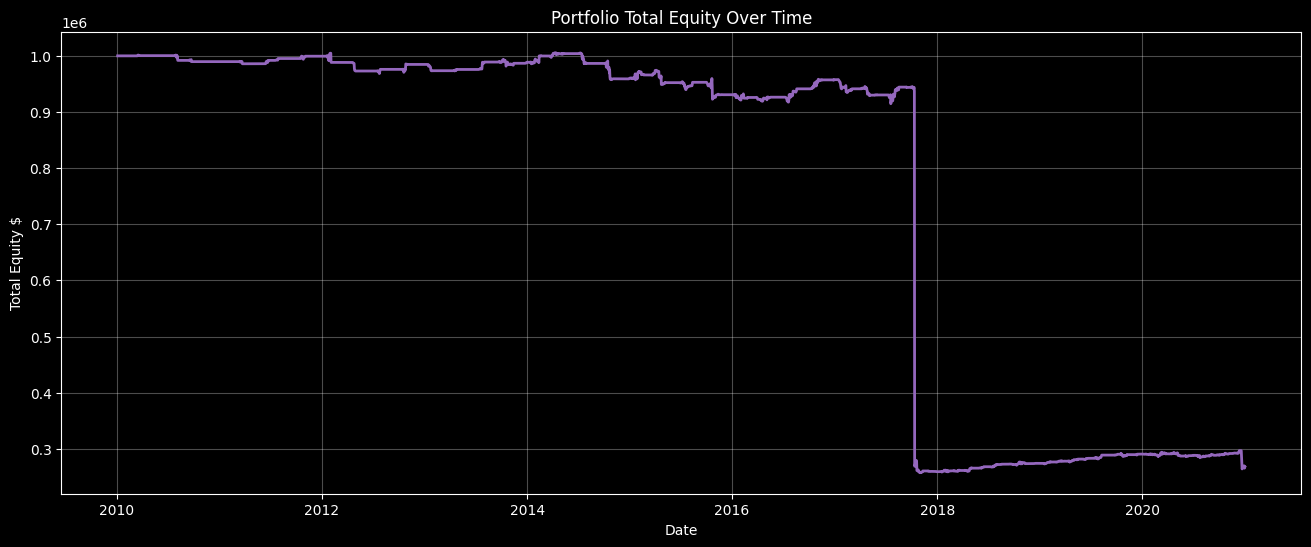

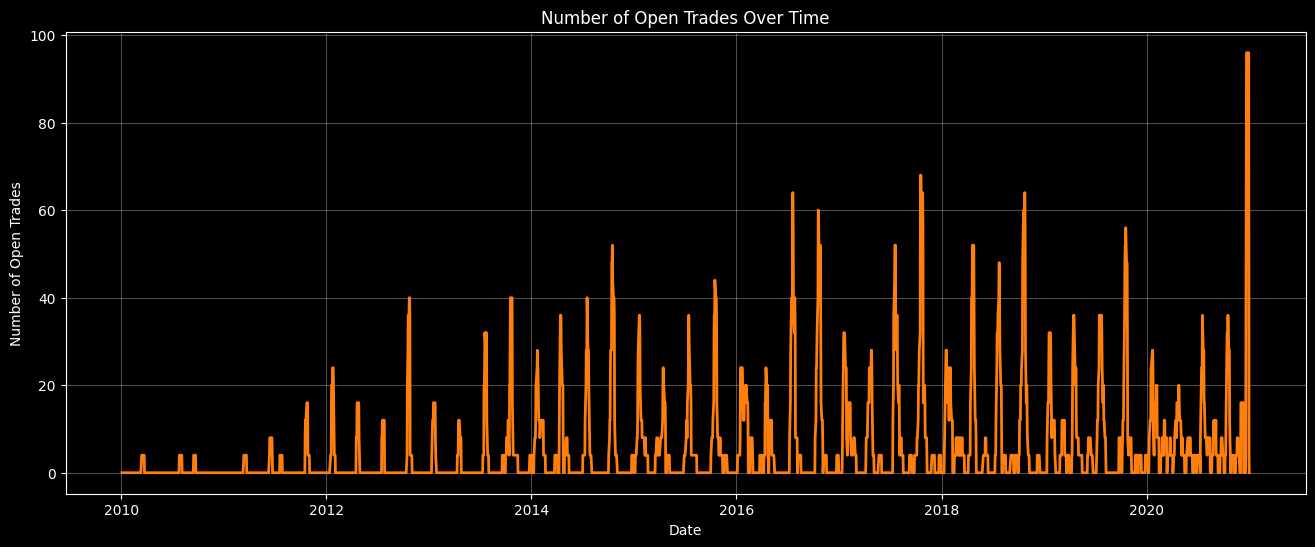

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx 
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
n_trades = np.array([len([key for key in snap.trade_equities.keys()]) for snap in result.snapshots])

dates = np.array([snap.date.to_datetime() for snap in result.snapshots])

fig2, ax2 = plt.subplots(figsize=(16, 6))
ax2.plot(dates, equity, color="tab:purple", lw=2, label="Total Equity")
ax2.grid(True, alpha=0.3)
ax2.set_title("Portfolio Total Equity Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Equity $")

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dates, n_trades, color="tab:orange", lw=2, label="Number of Open Trades")
ax.grid(True, alpha=0.3)
ax.set_title("Number of Open Trades Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Open Trades")  

In [8]:
[i.entry_data for i in (result.snapshots[2301].trade_equities.keys())]


[EntryData(entry_date=DateObj(year=2019, month=2, day=26), position_type=<PositionType.SHORT: 'short'>, price_series=PriceSeries(tick='COST', prices={'2019-02-26': Option(bid=4.75, ask=5.05, volume=1.0, date=DateObj(year=2019, month=2, day=26), tick='COST', option_type=<OptionType.CALL: 'c'>, strike=220.0, expiry=DateObj(year=2019, month=3, day=29), iv=0.21545, underlying=Spot(bid=217.61000061035156, ask=217.61000061035156, volume=0.0, date=DateObj(year=2019, month=2, day=26), tick='COST', underlying_type=<UnderlyingType.SPOT: 'Spot'>), rfr=None, delta=0.476, gamma=0.0299, vega=0.2532, theta=-0.0958, rho=0.0842, other={'recent_high_low': 50.37998962402344}, underlying_type=<UnderlyingType.OPTION: 'Option'>), '2019-02-27': Option(bid=4.6, ask=4.8, volume=43.0, date=DateObj(year=2019, month=2, day=27), tick='COST', option_type=<OptionType.CALL: 'c'>, strike=220.0, expiry=DateObj(year=2019, month=3, day=29), iv=0.2129, underlying=Spot(bid=218.0500030517578, ask=218.0500030517578, volume=0

C:\Users\cameronA\AppData\Local\Temp\ipykernel_25296\3139008102.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(16, 6))


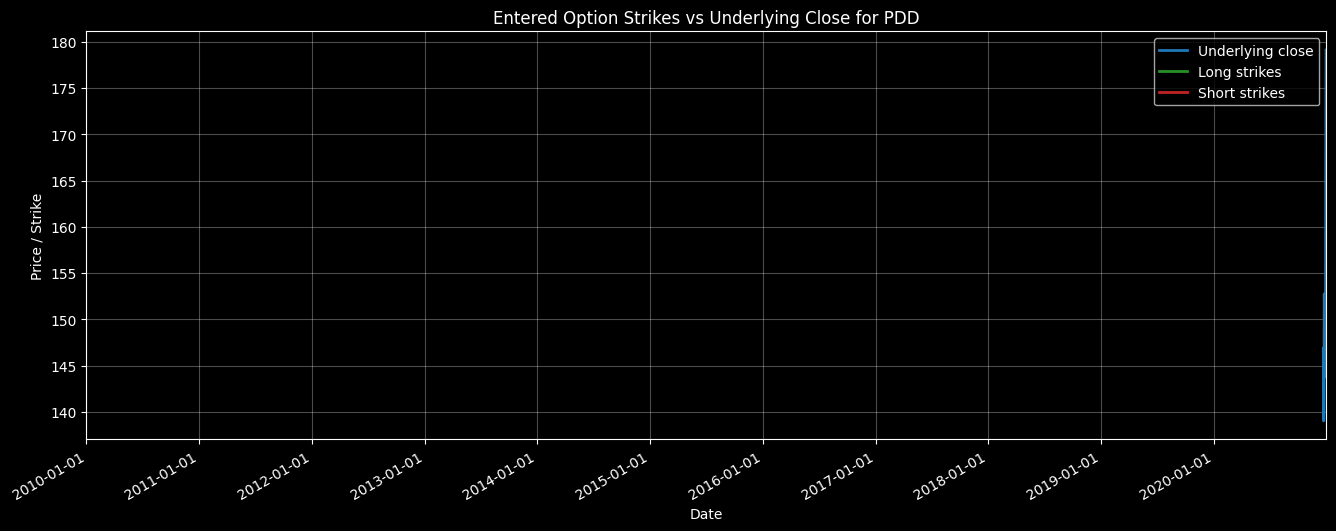

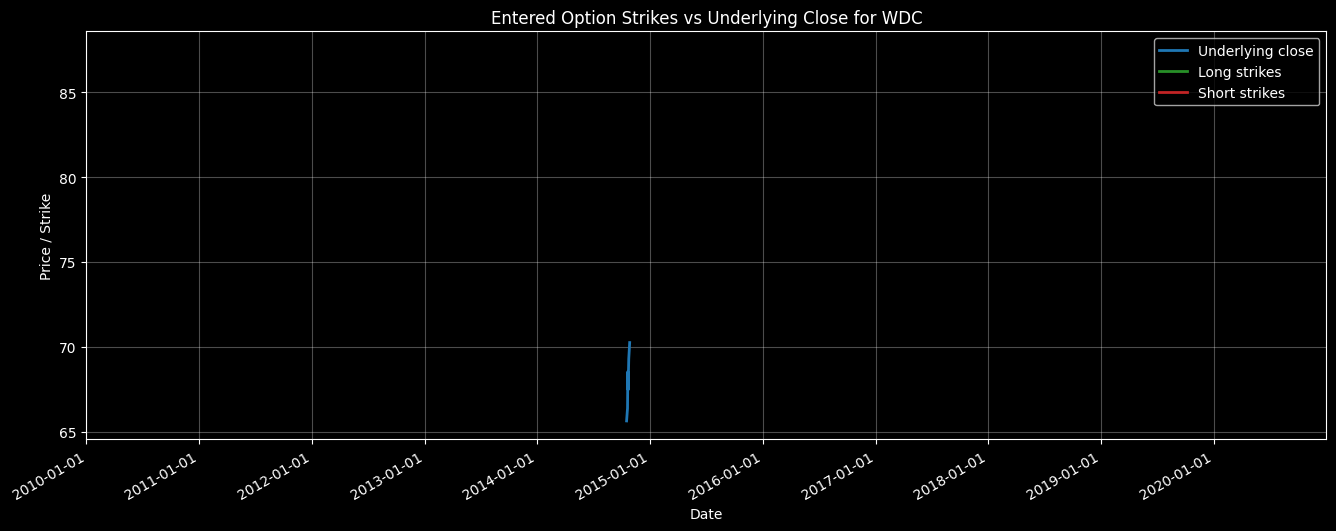

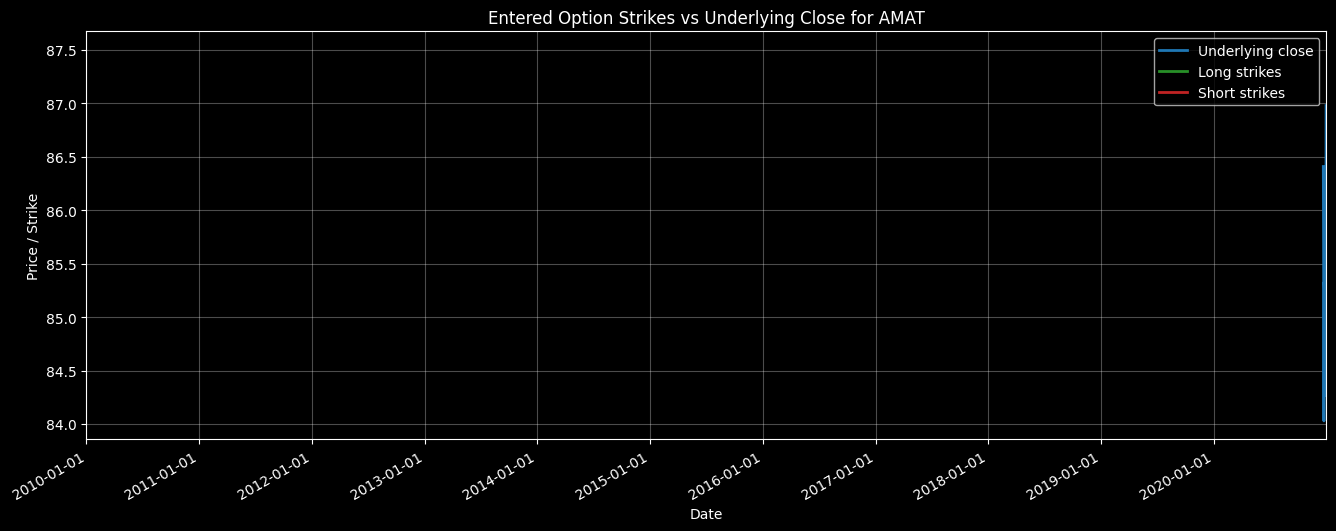

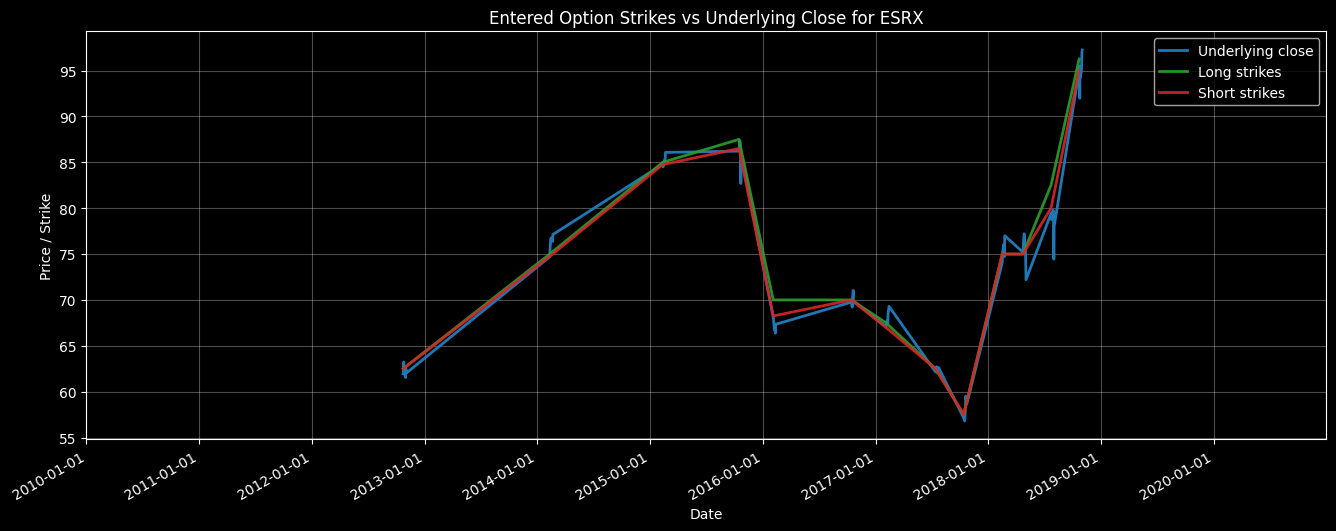

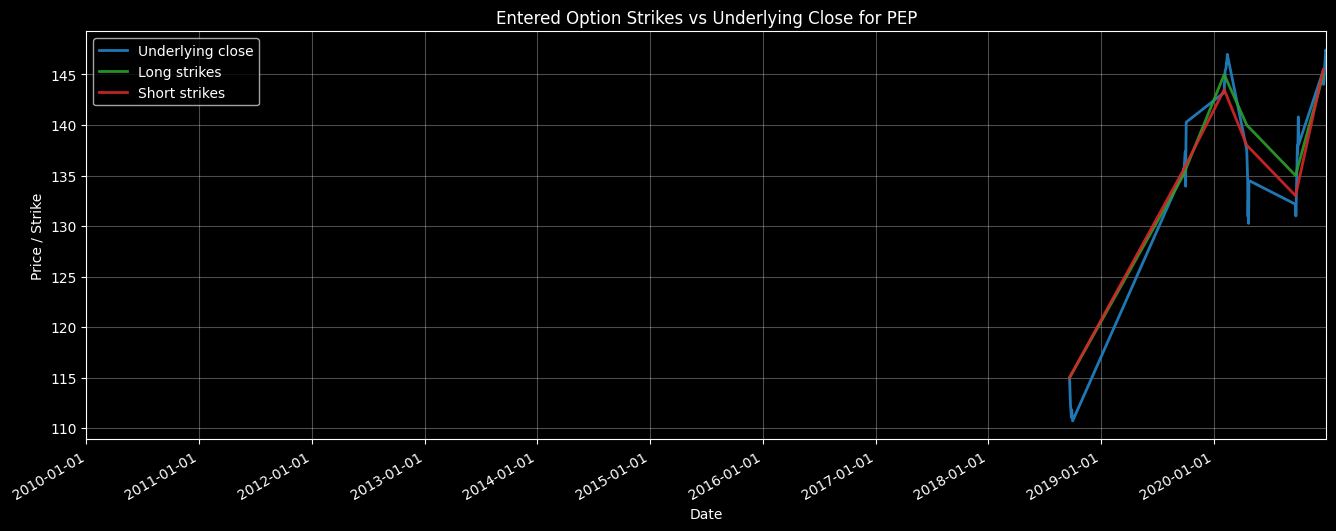

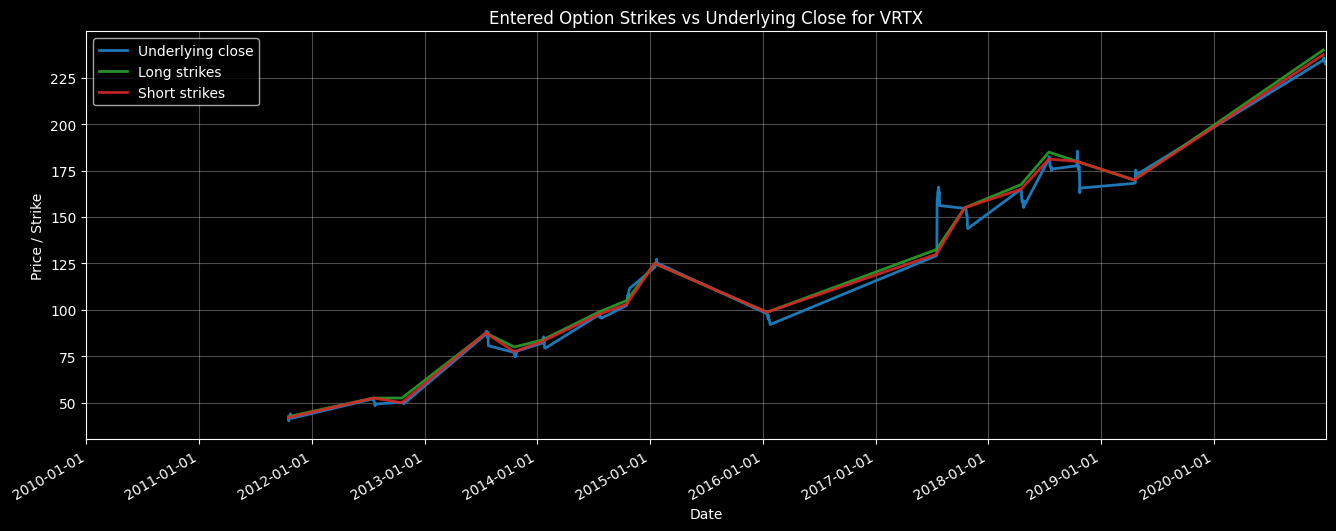

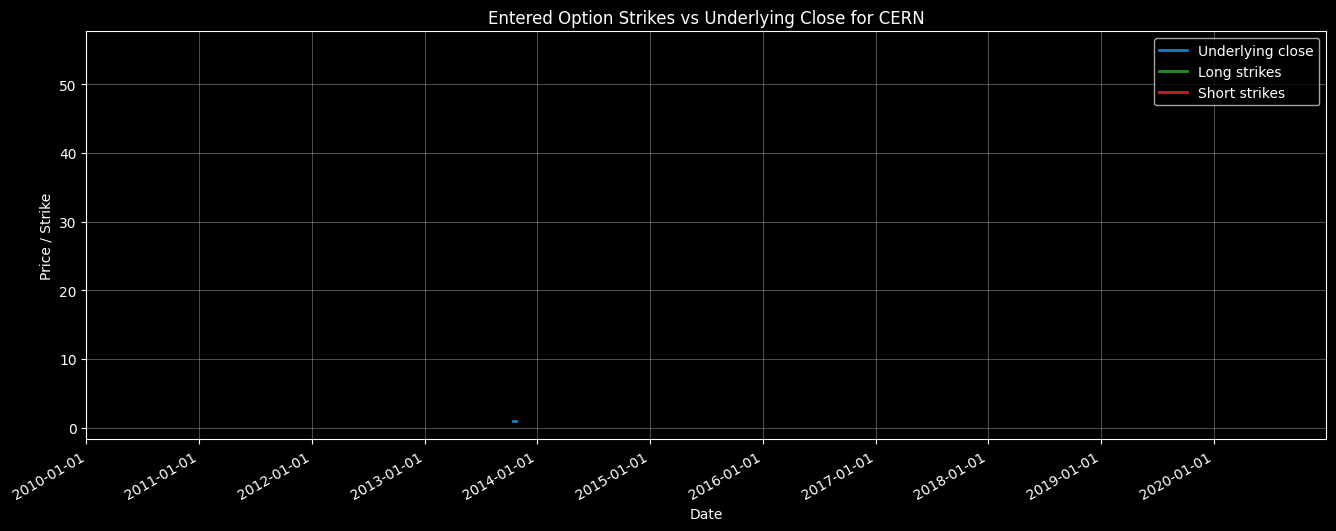

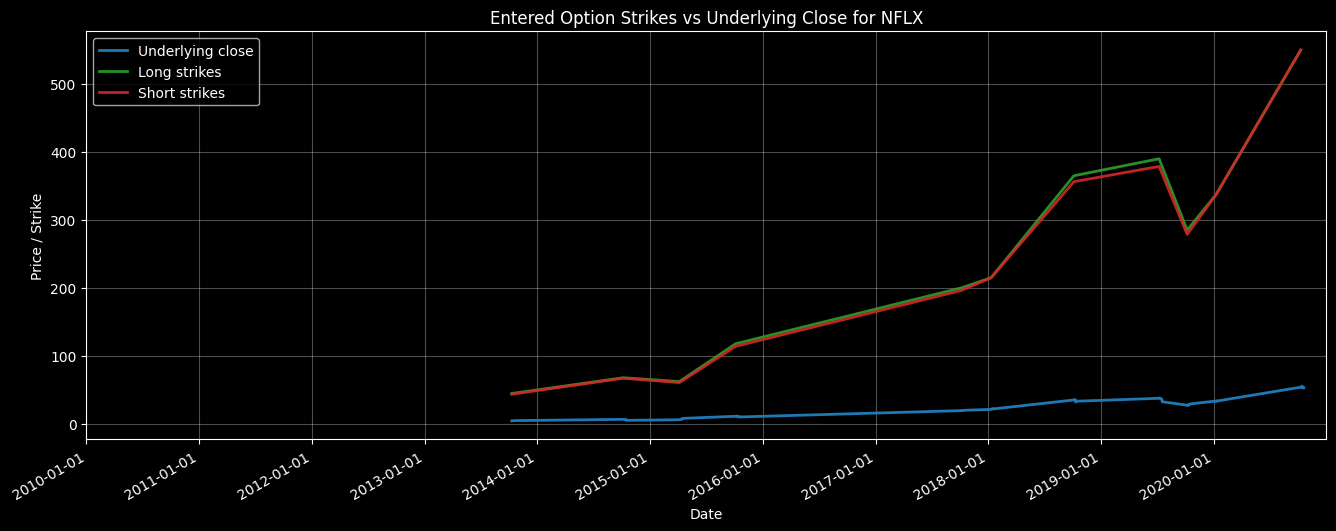

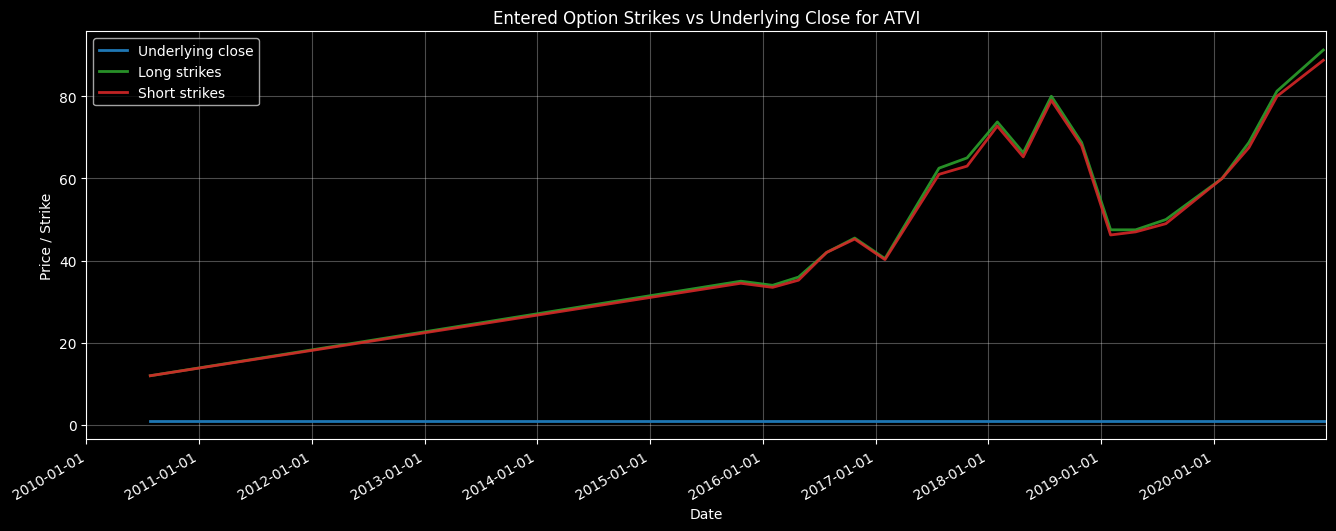

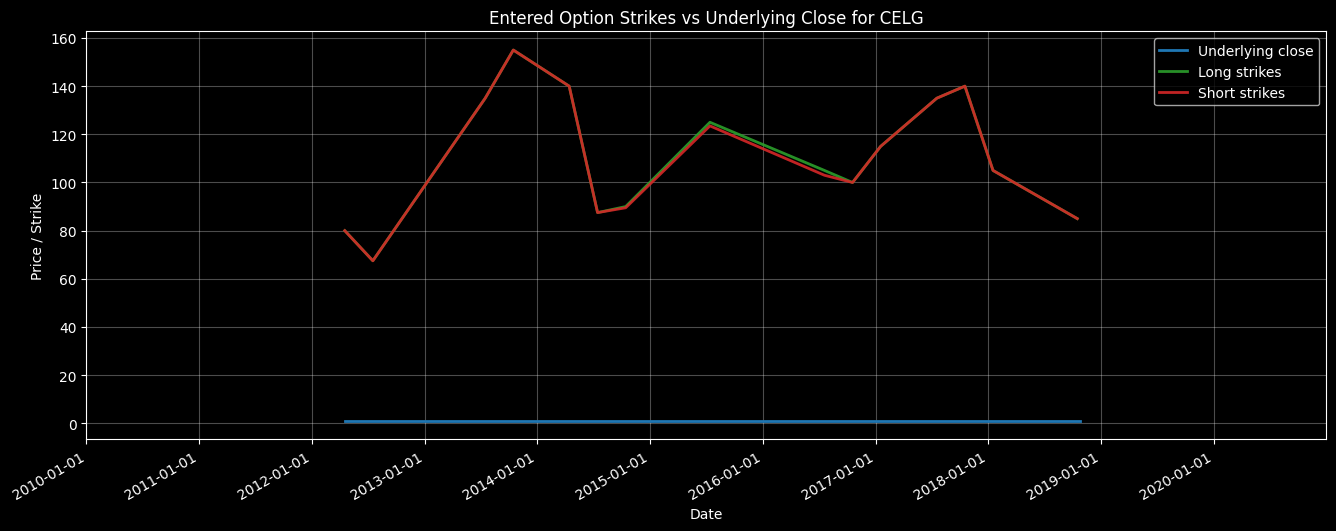

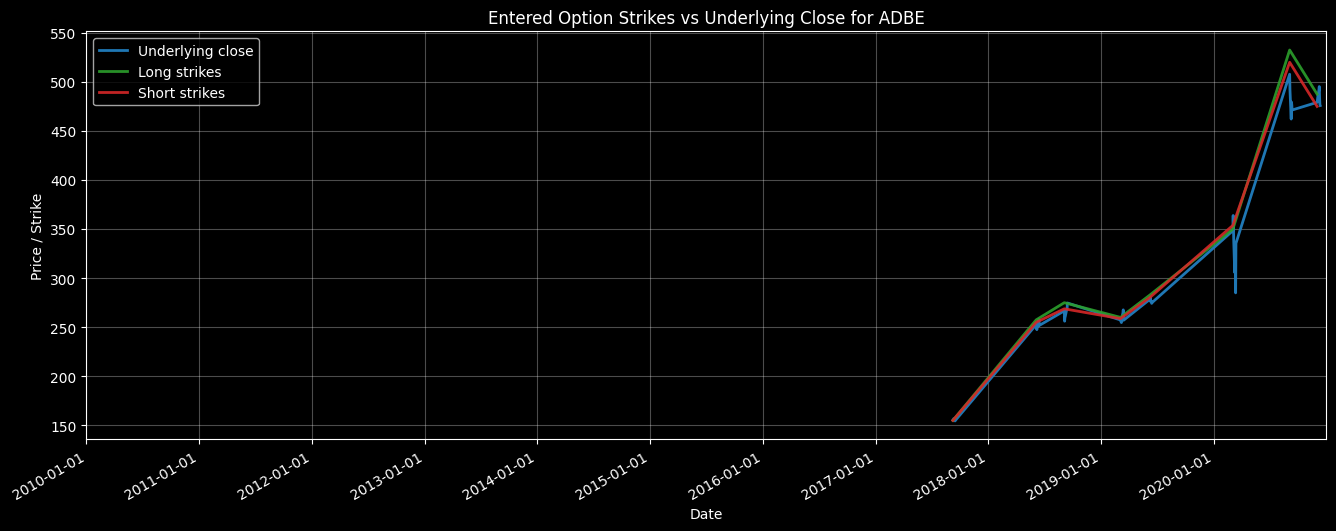

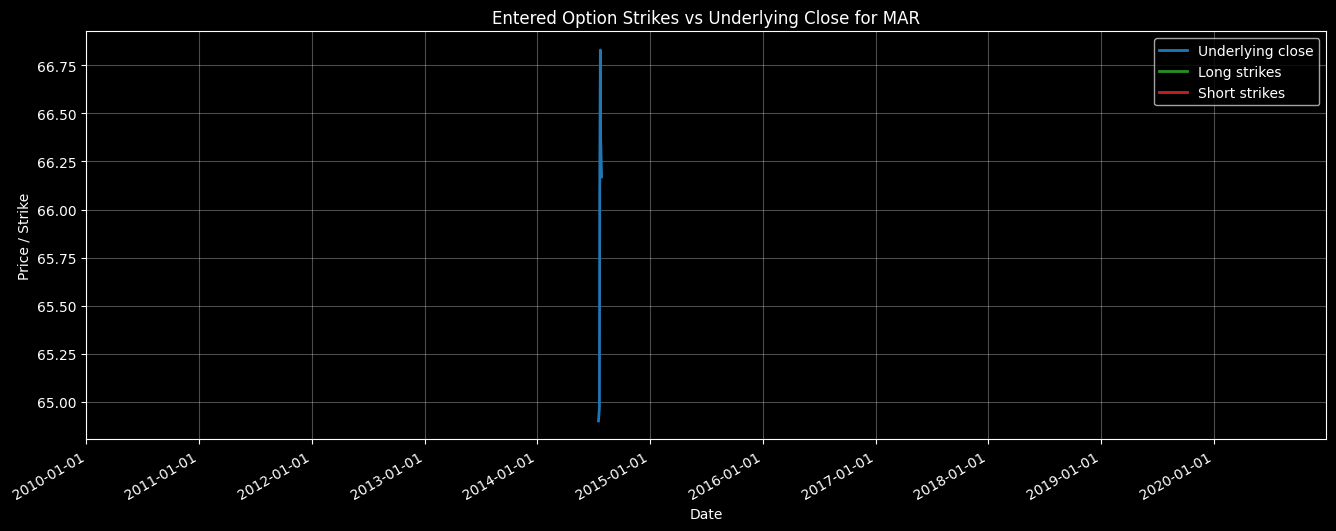

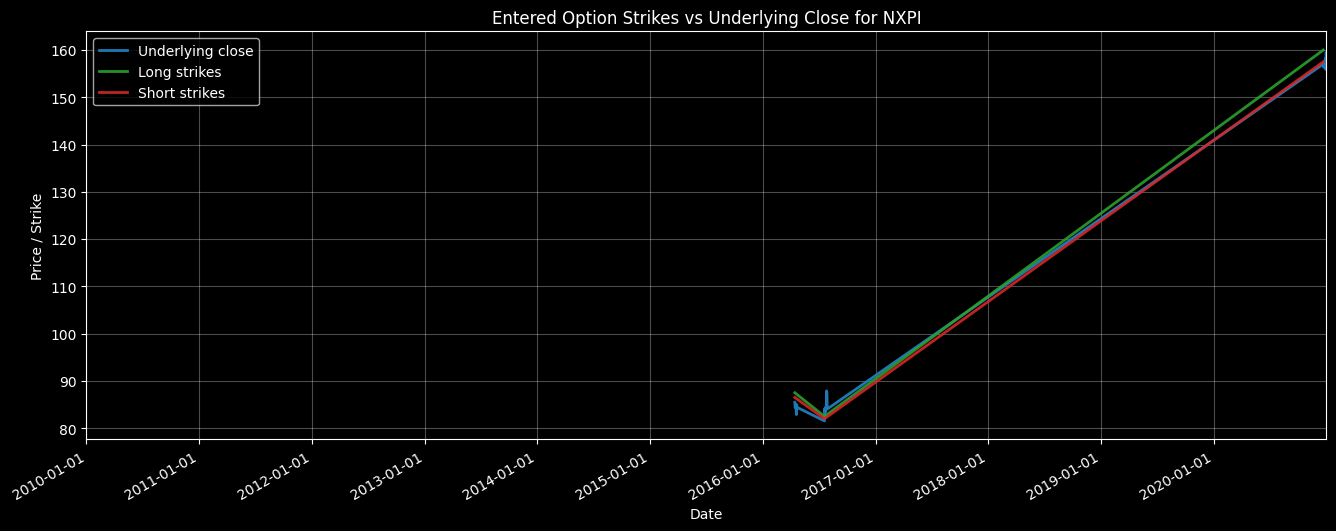

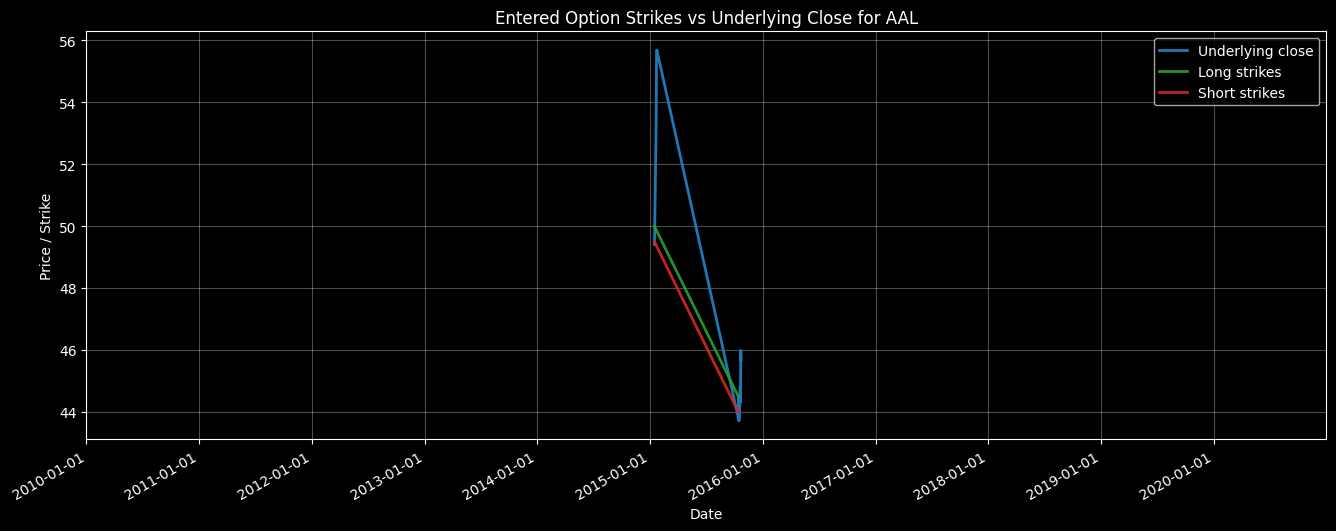

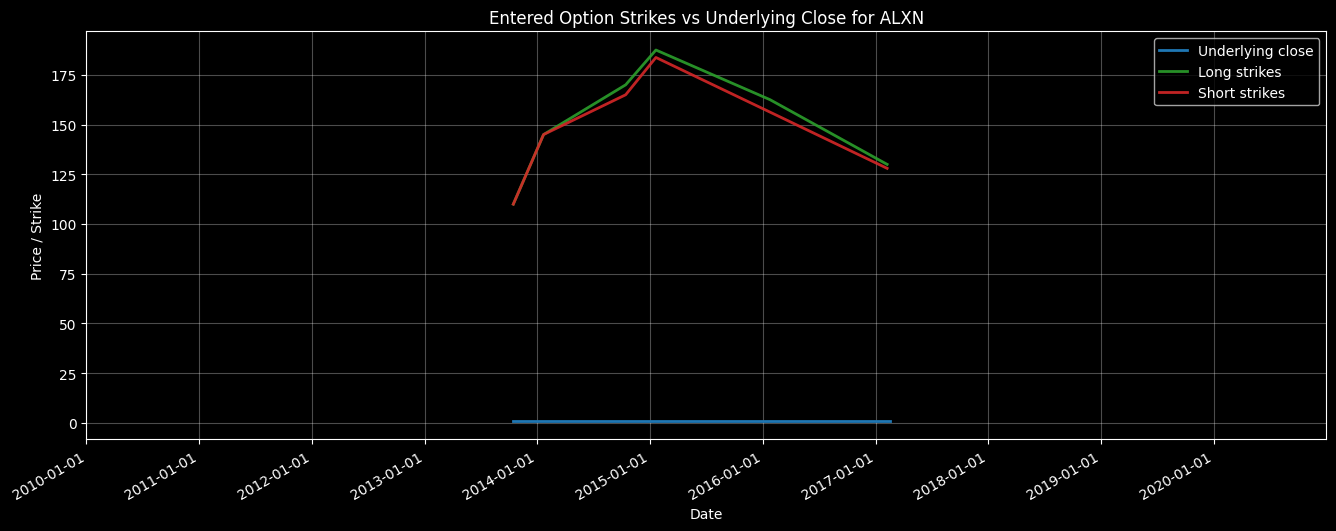

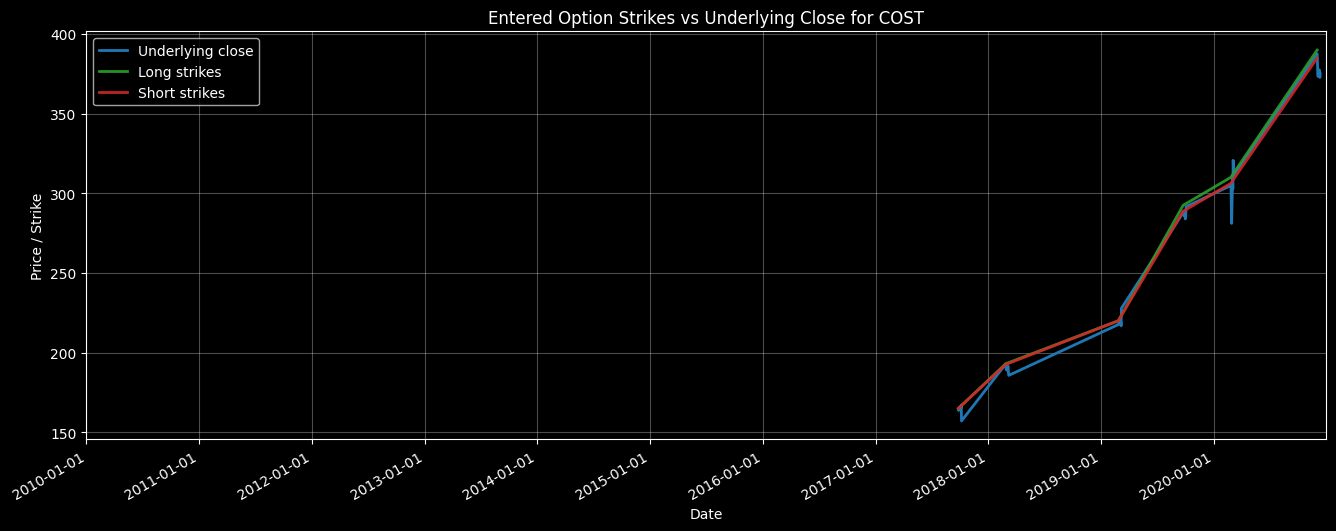

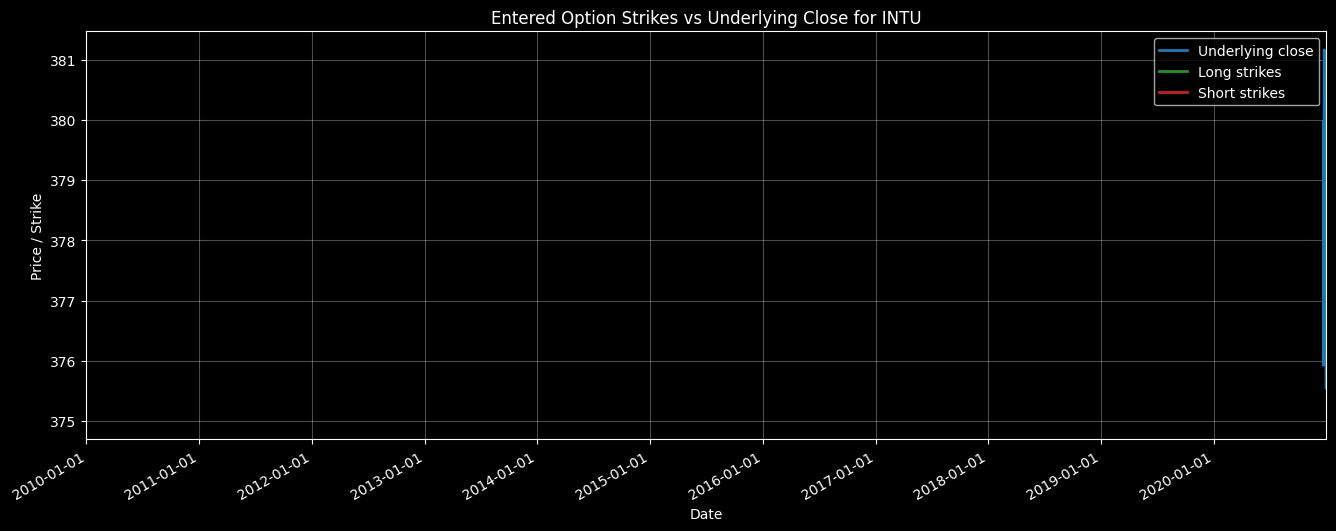

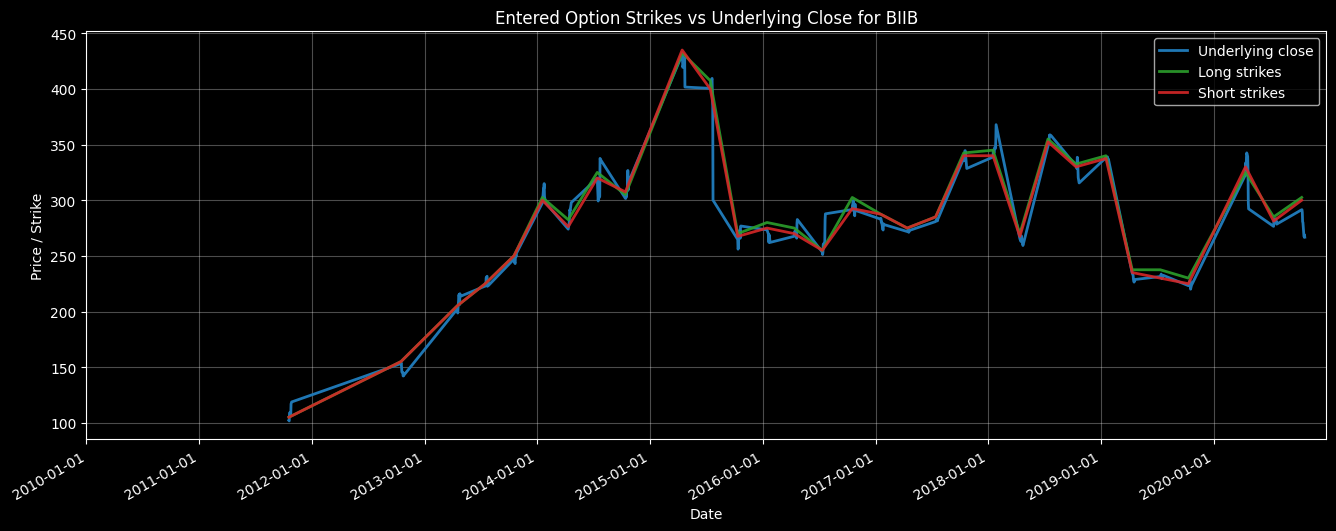

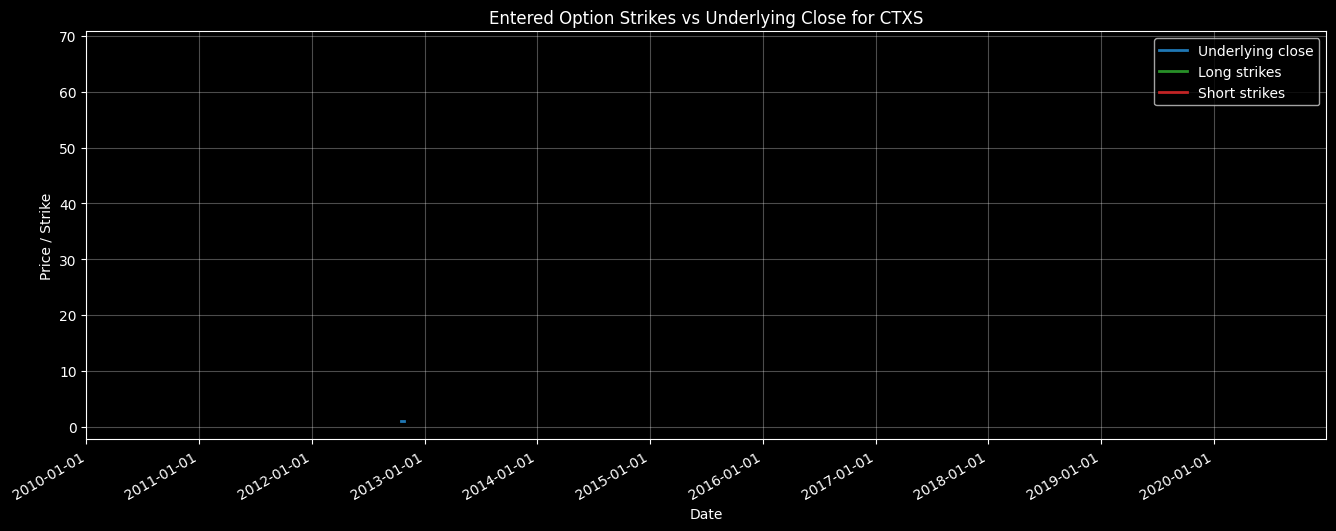

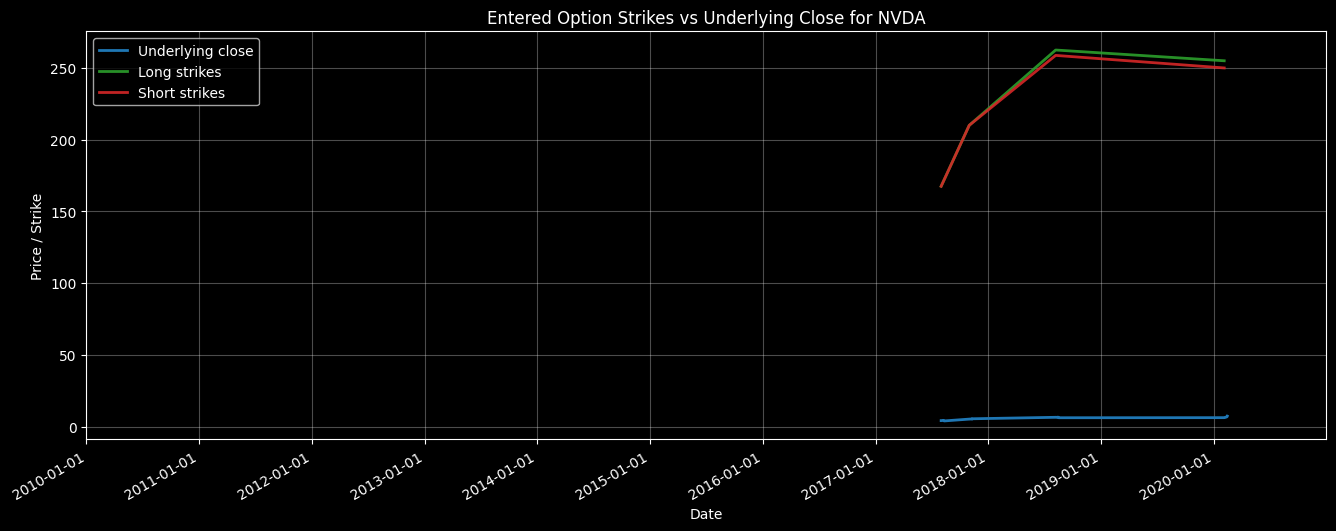

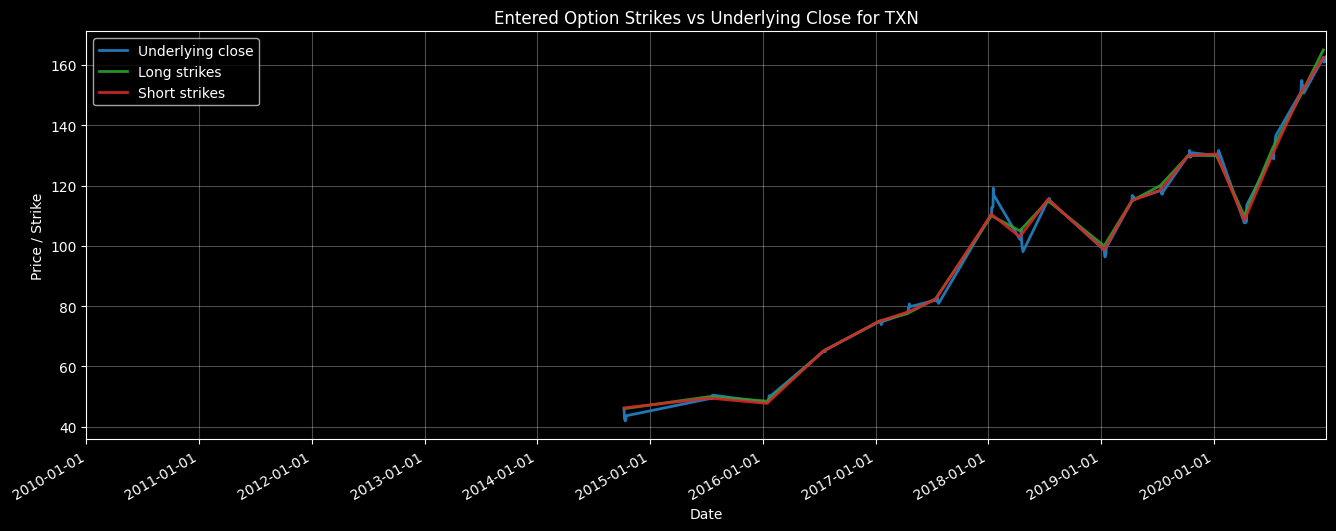

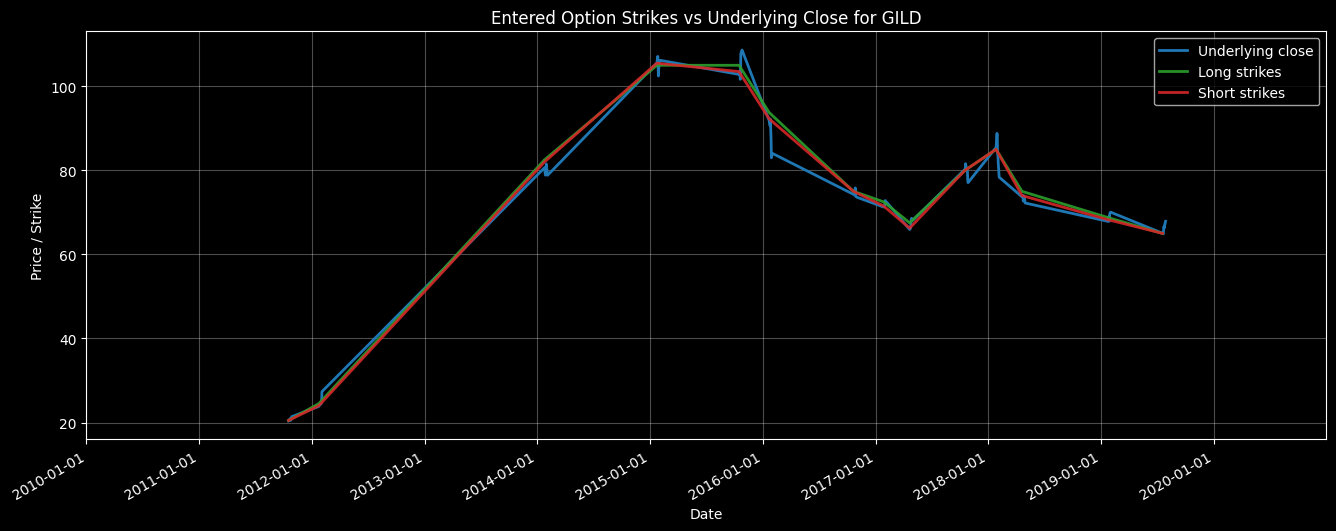

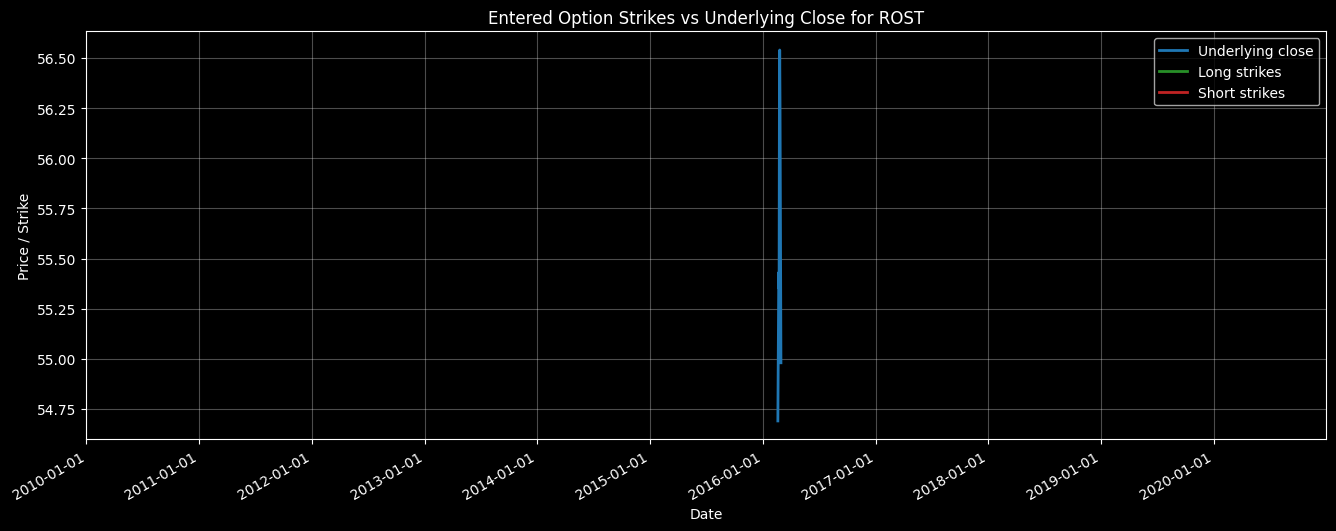

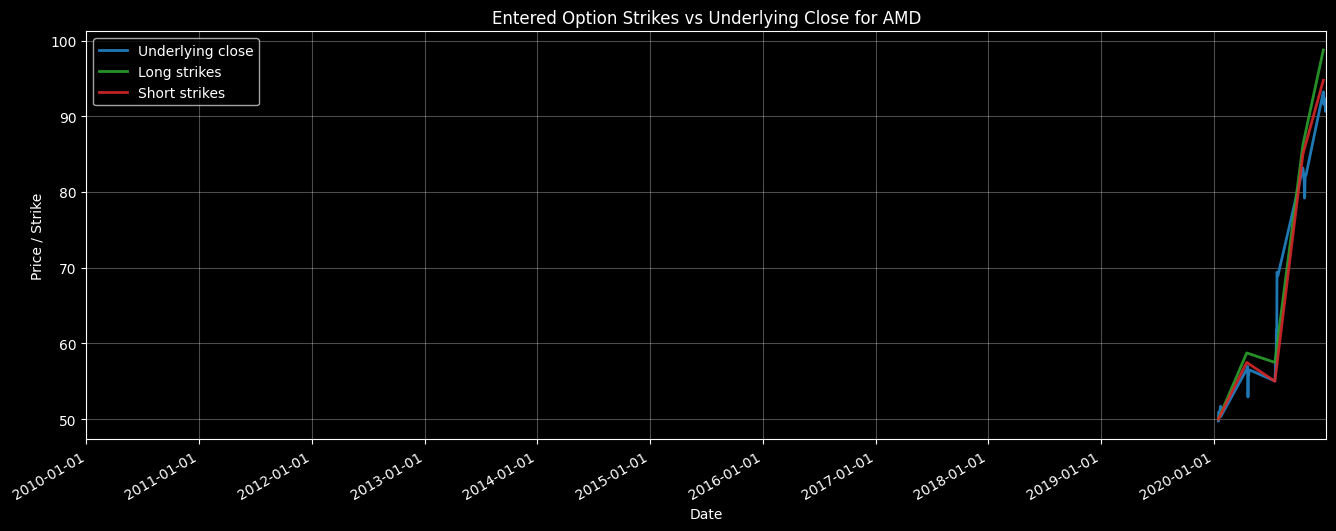

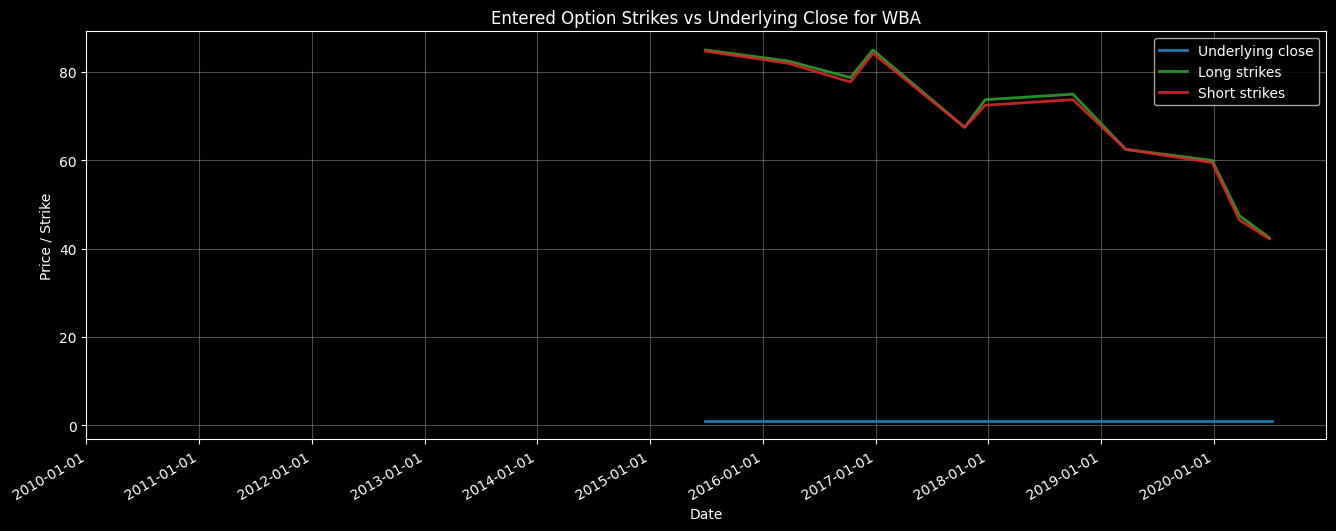

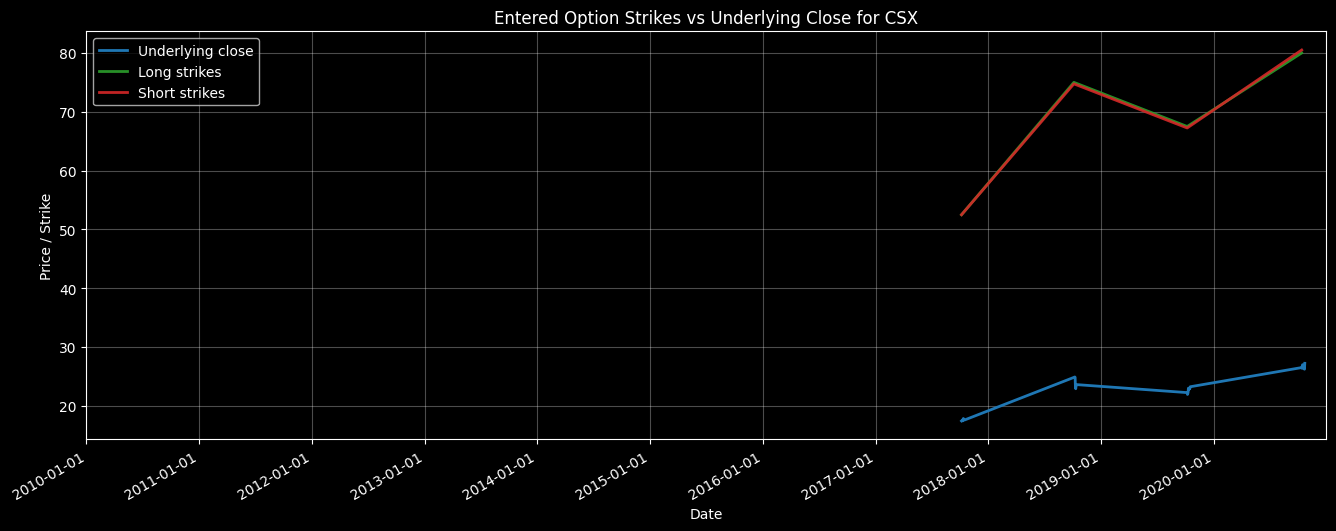

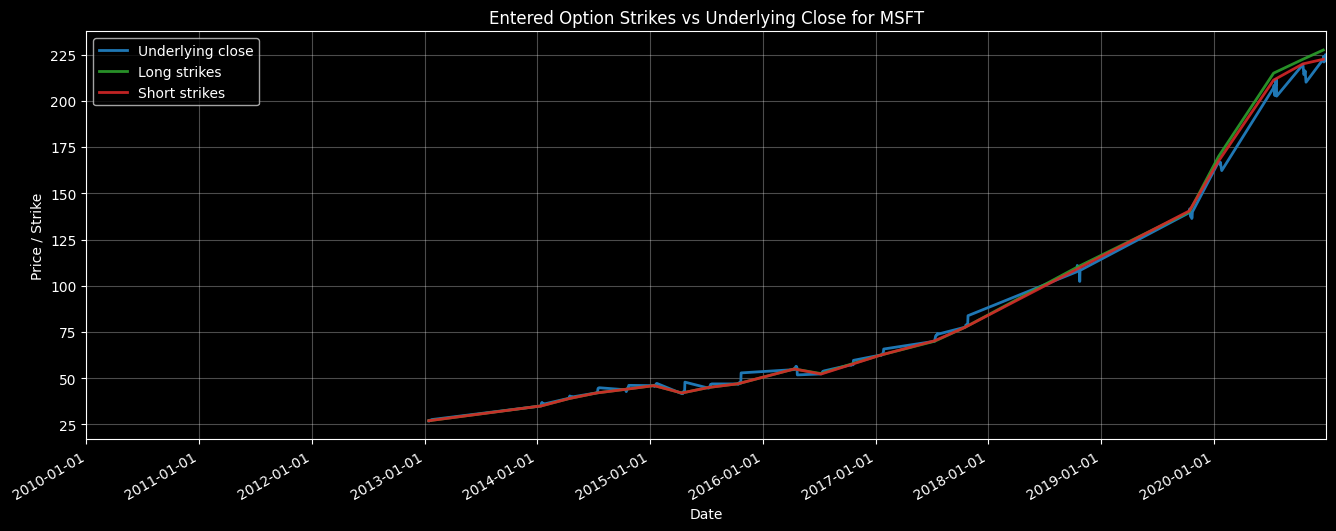

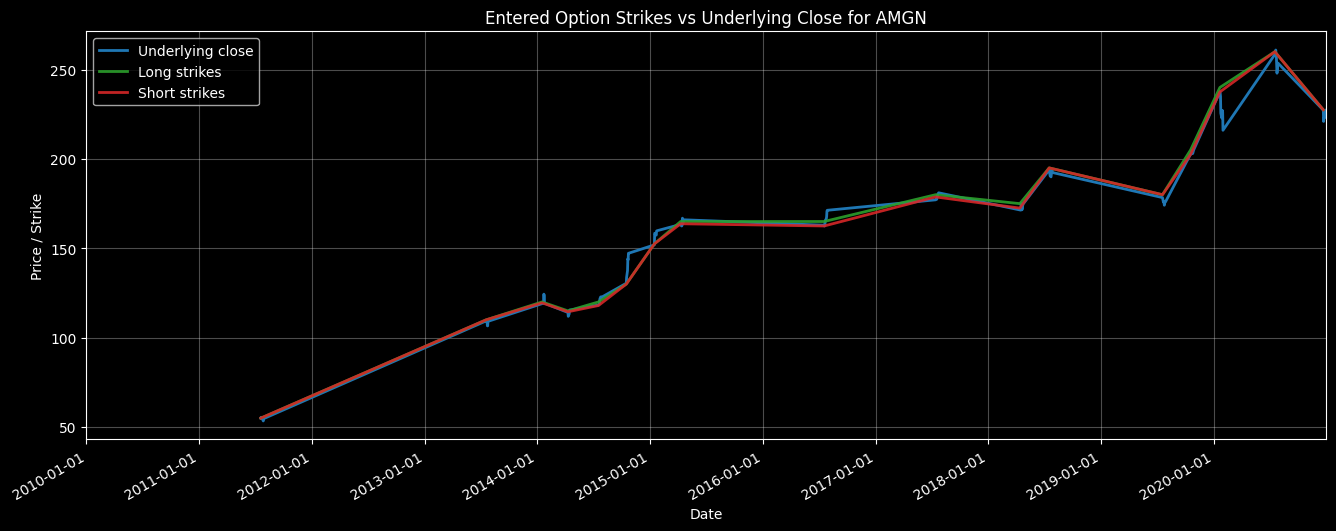

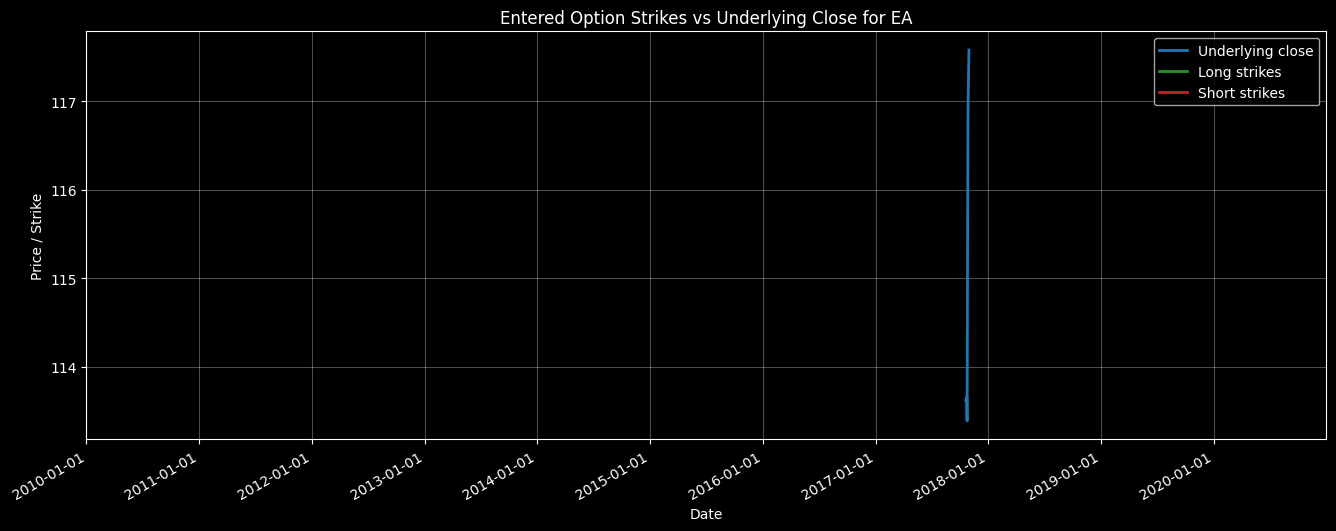

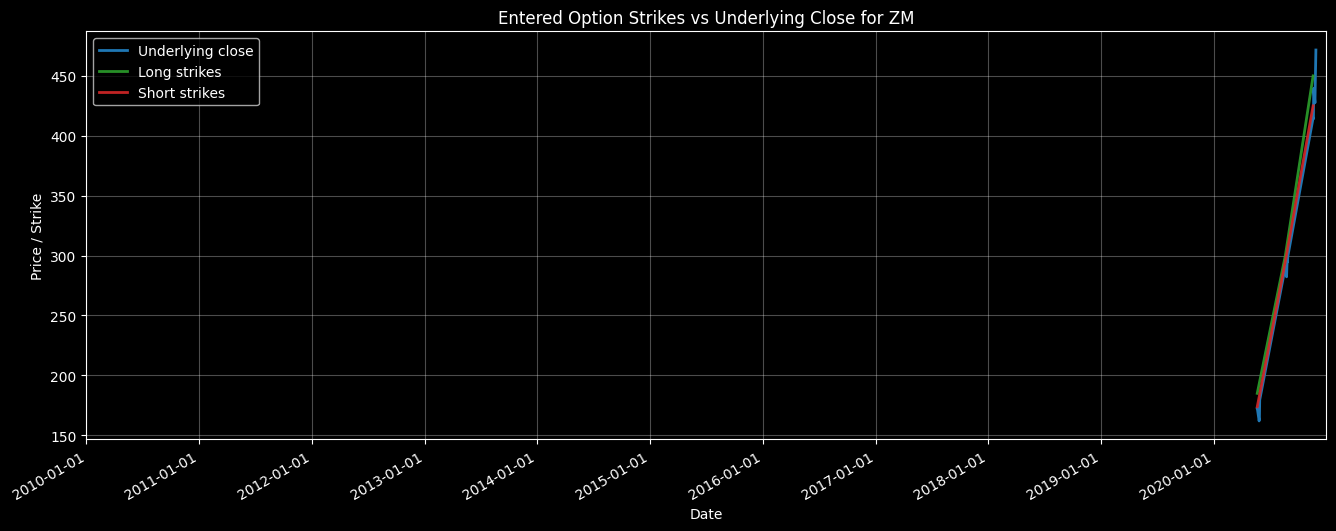

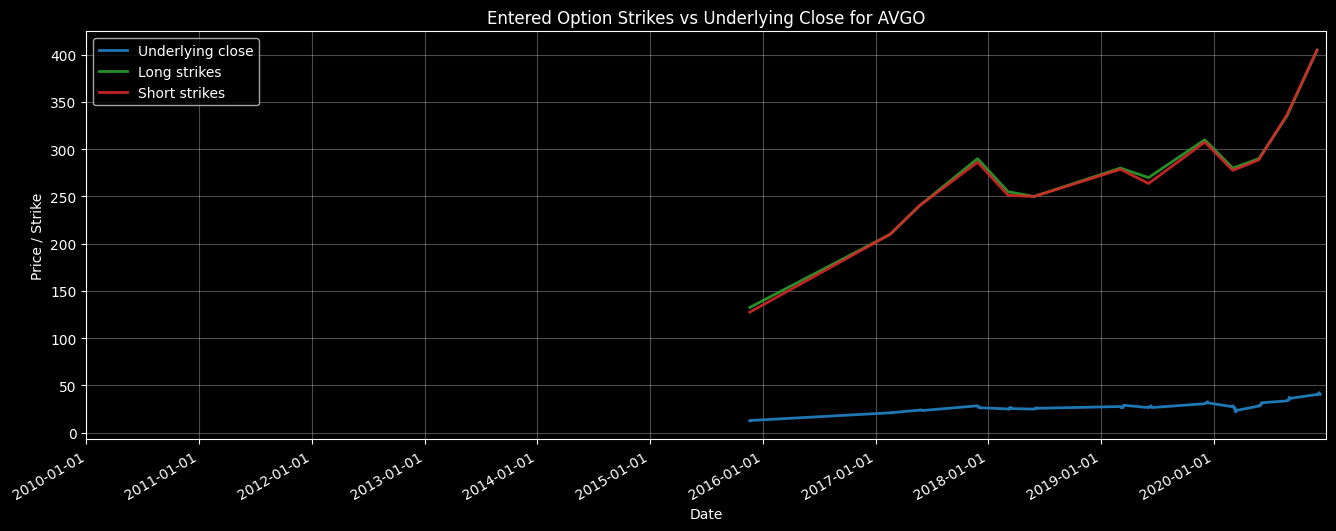

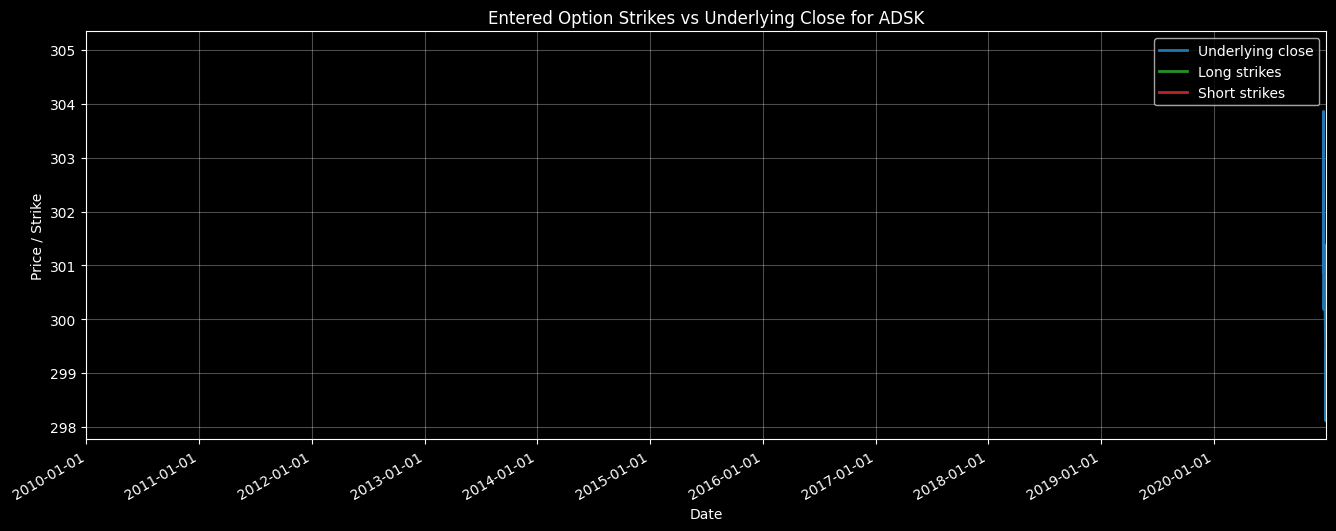

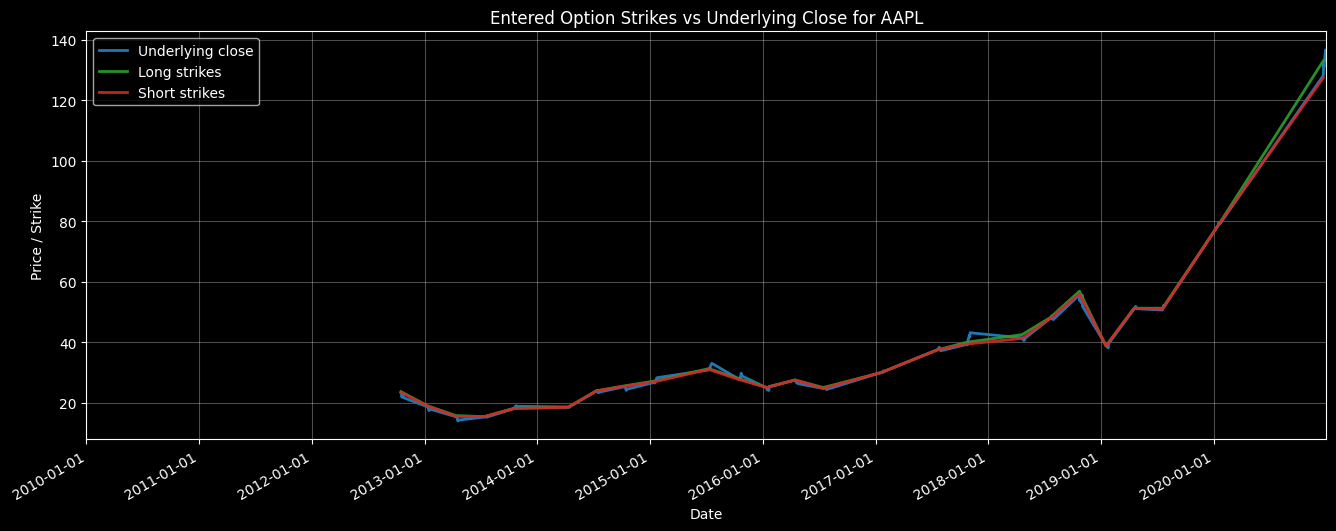

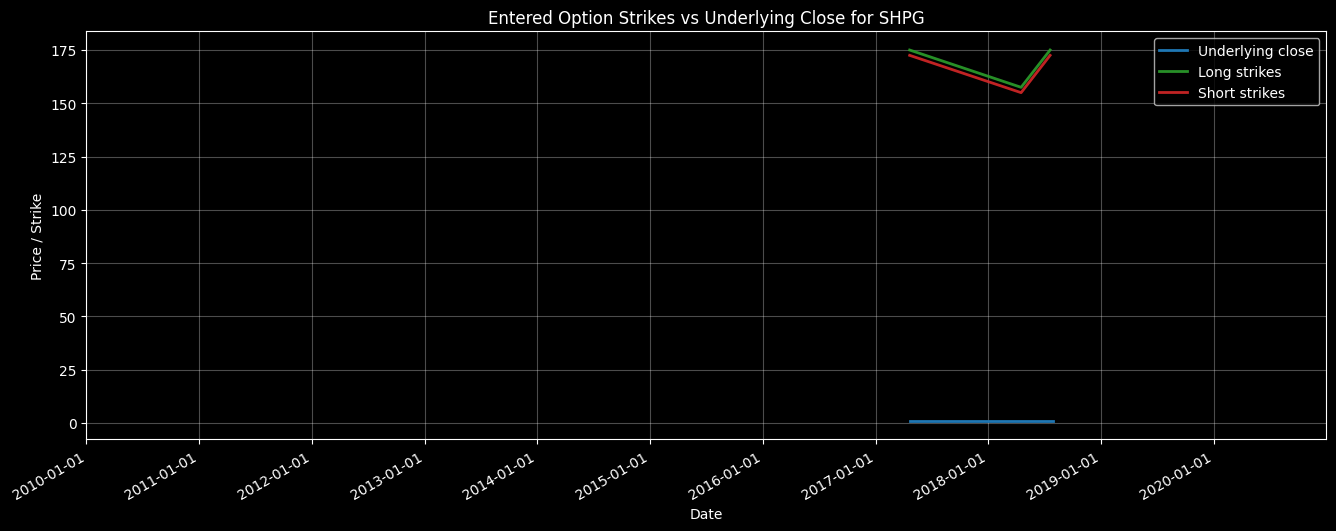

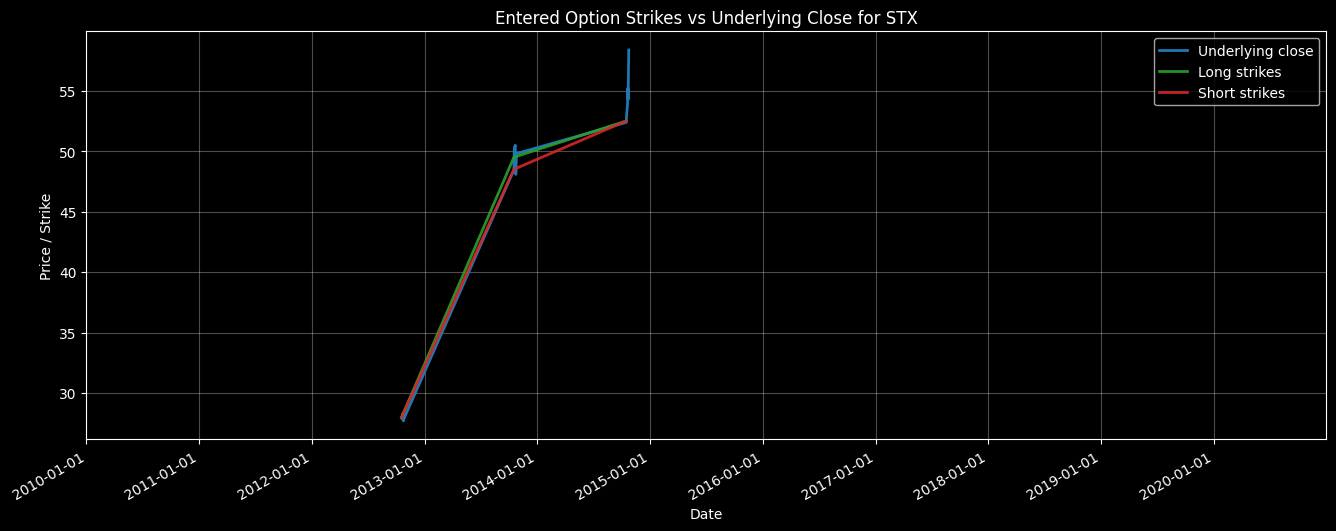

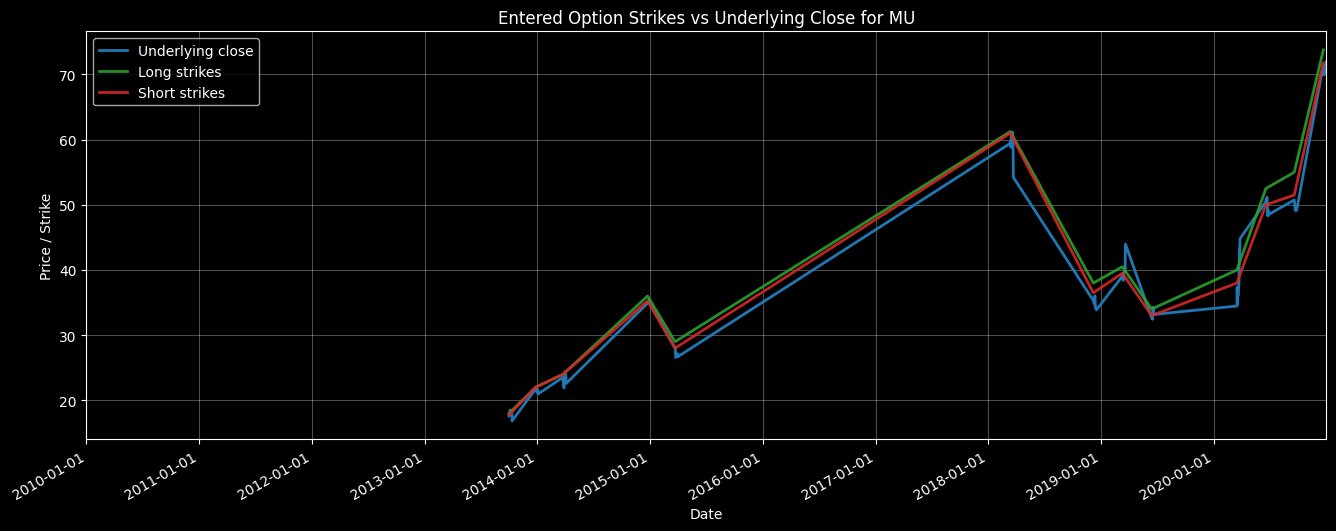

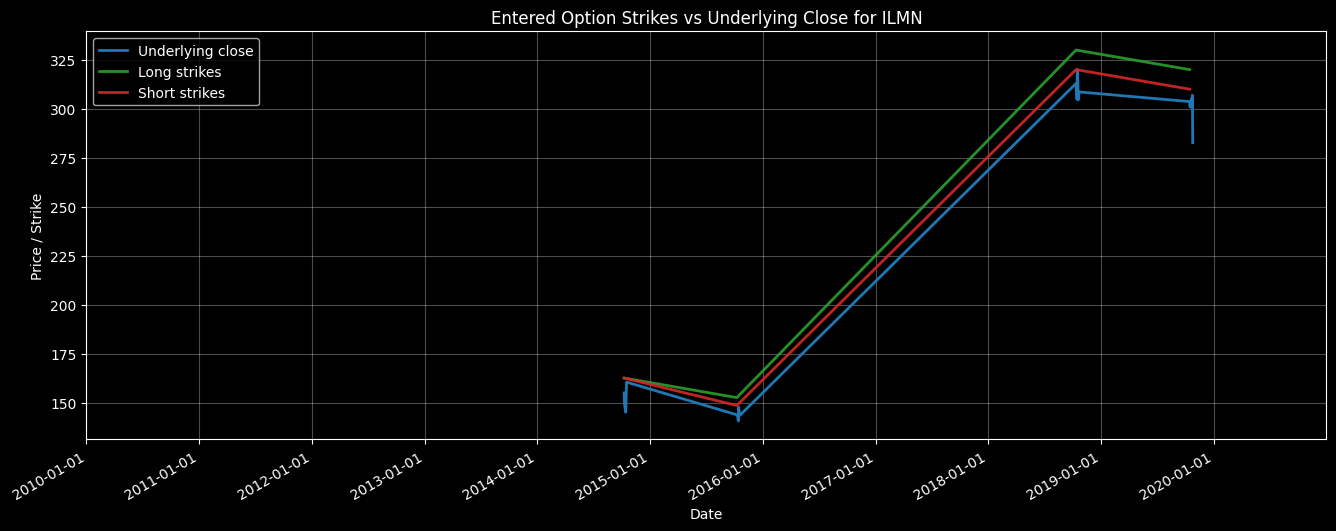

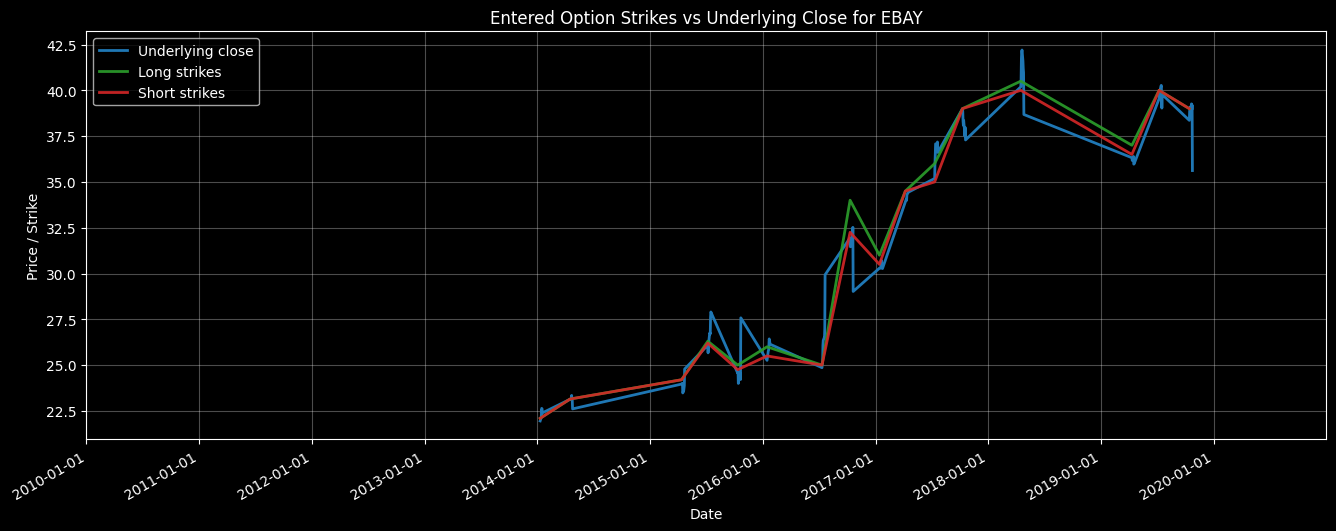

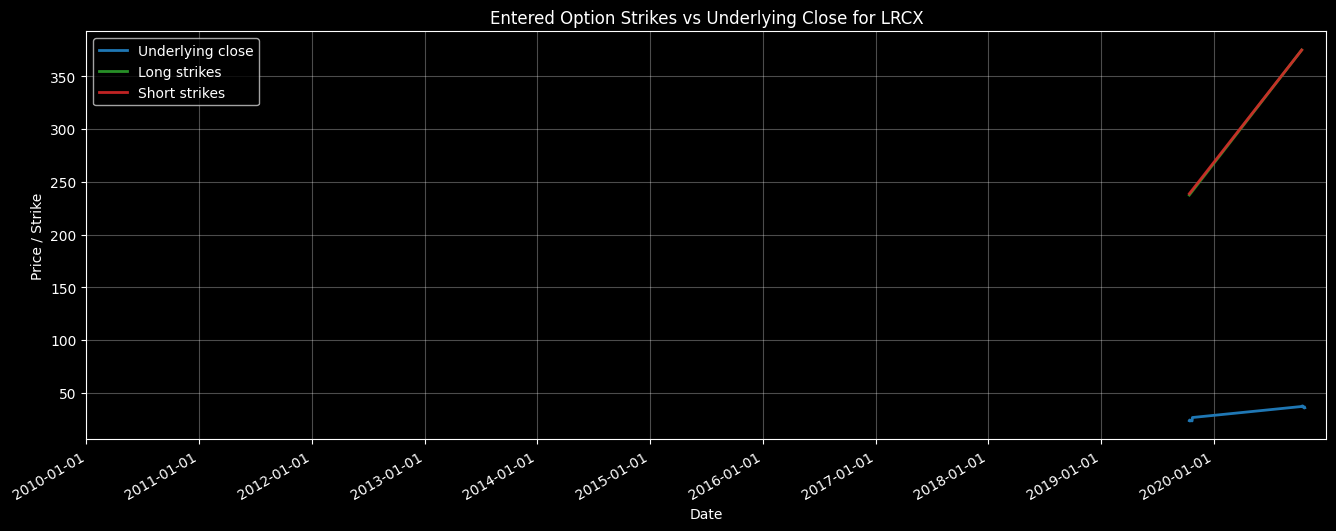

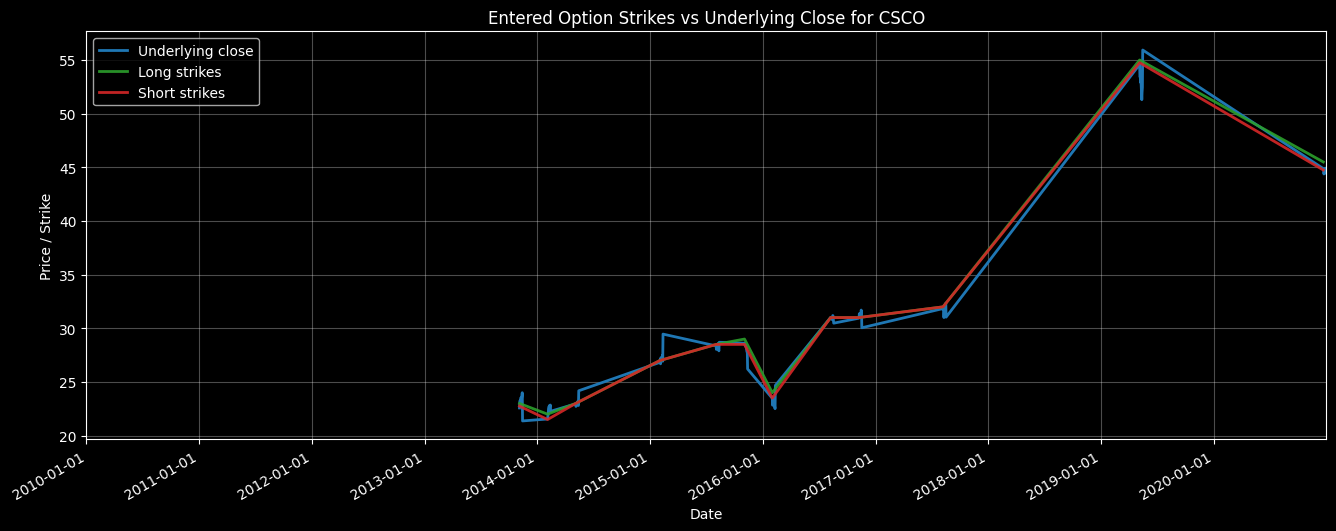

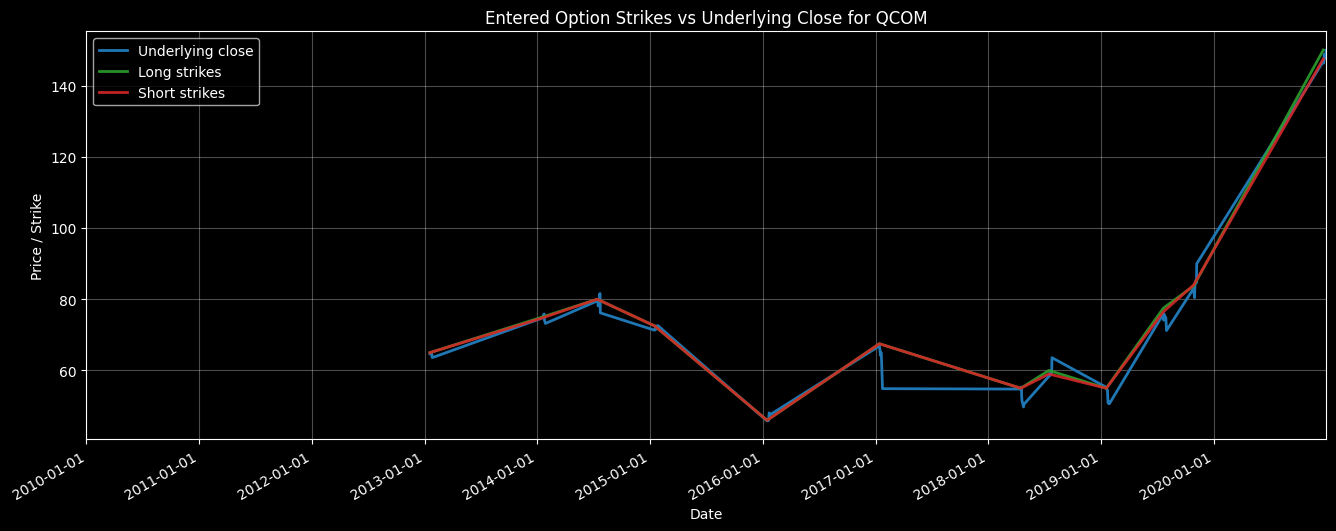

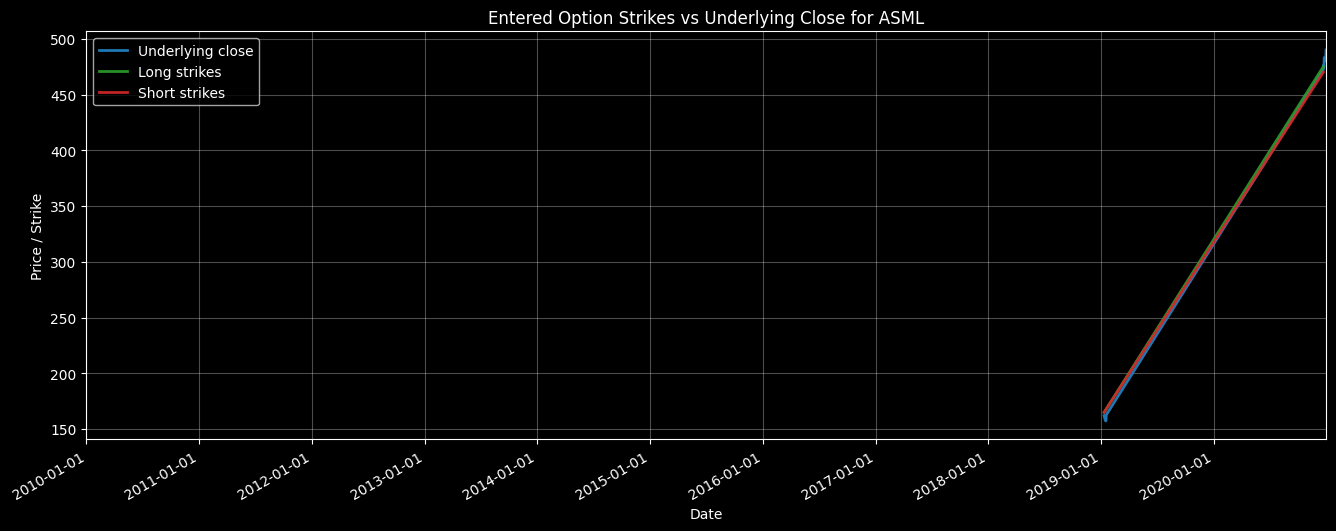

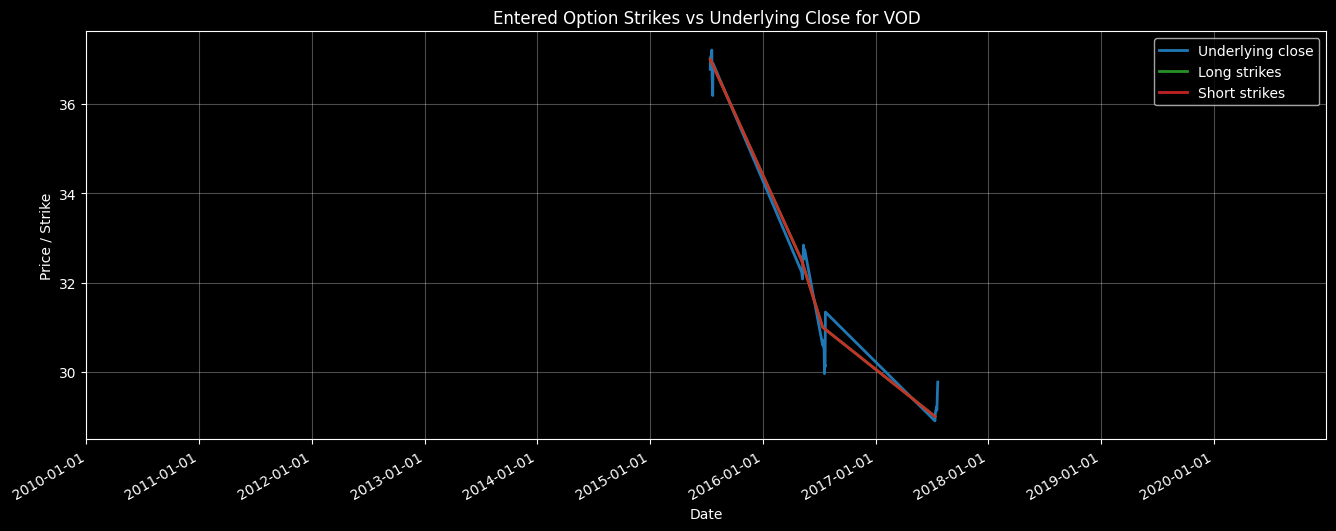

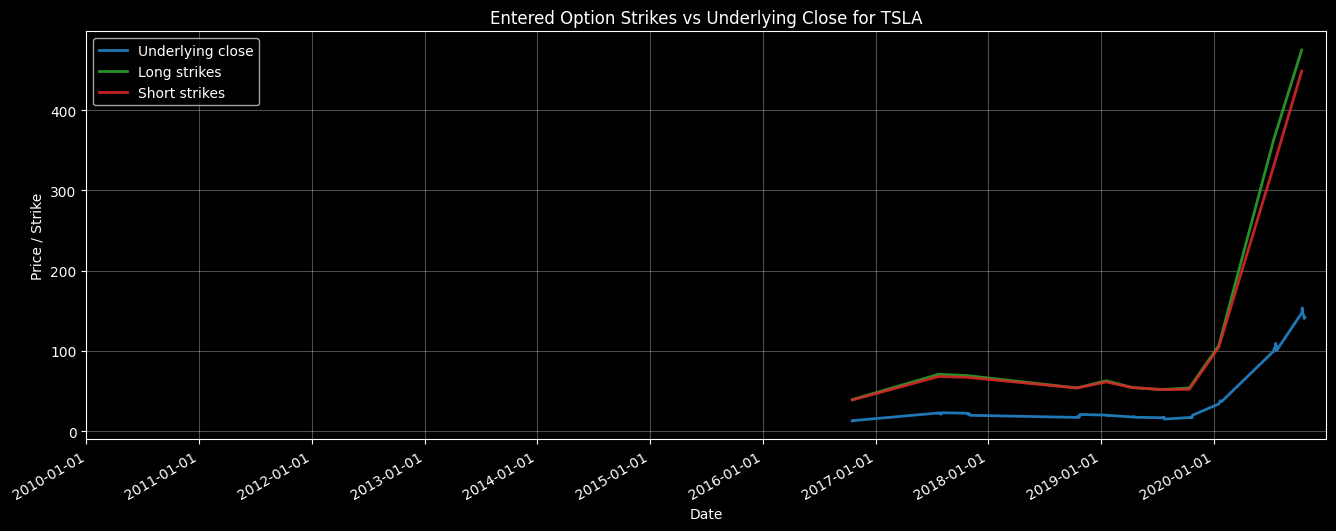

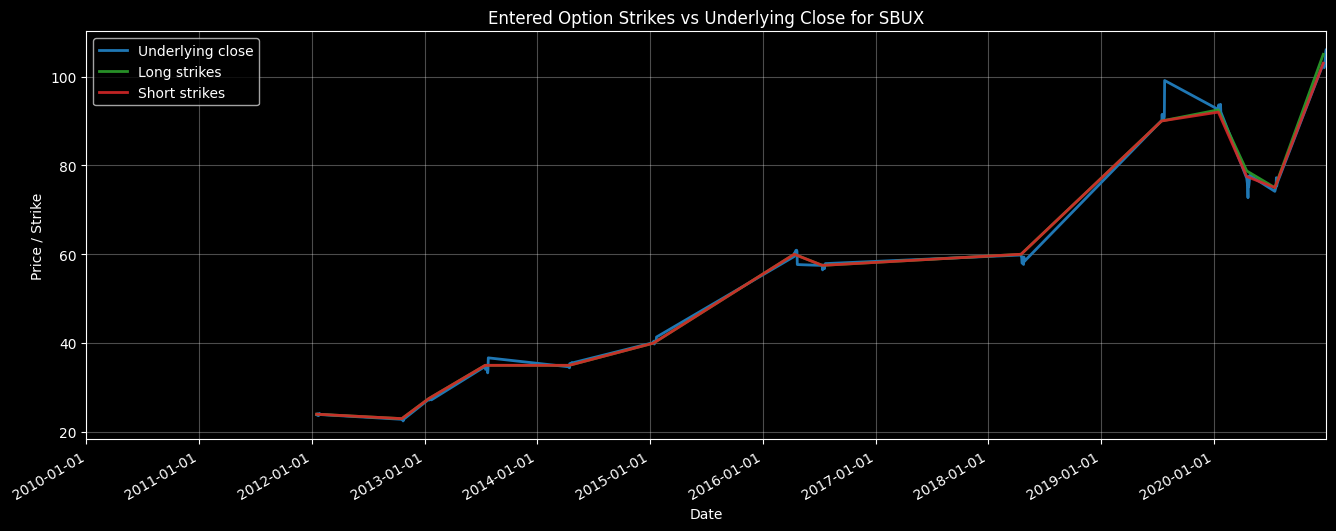

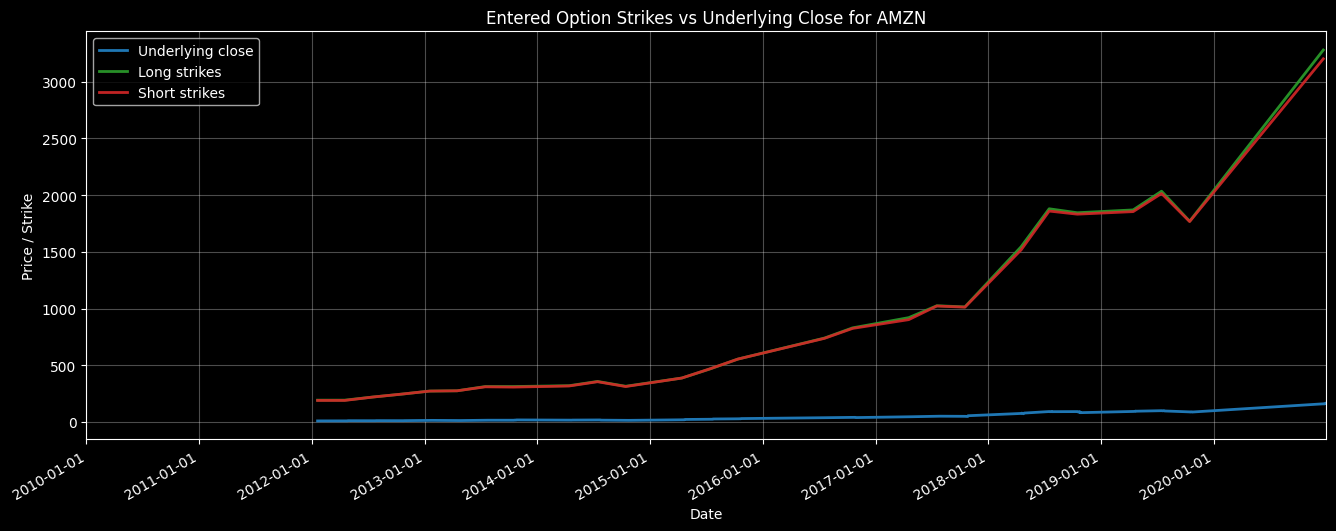

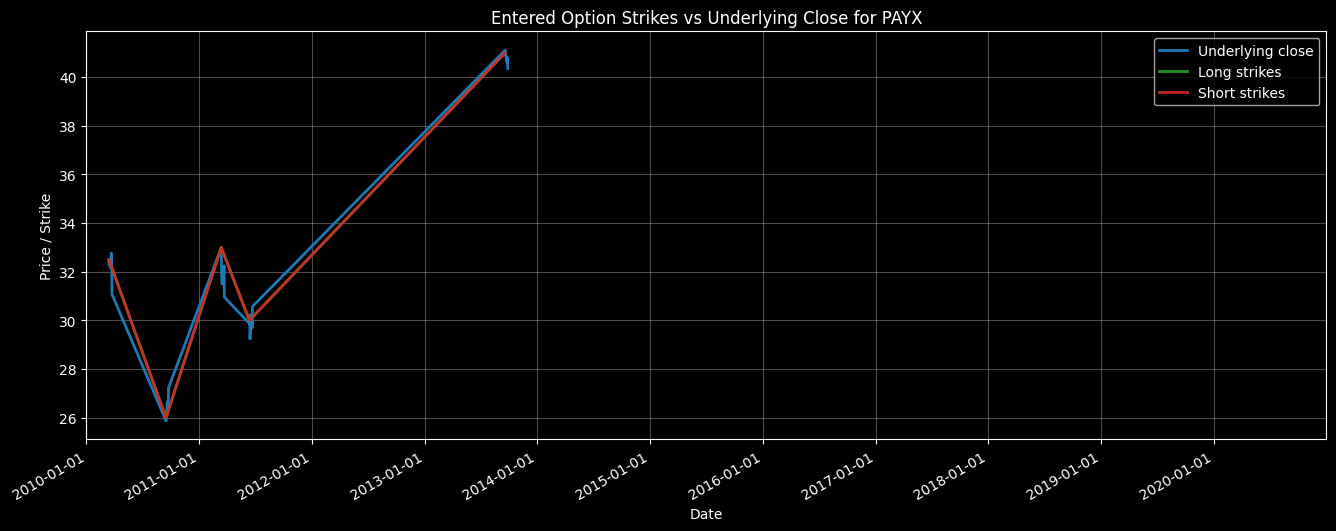

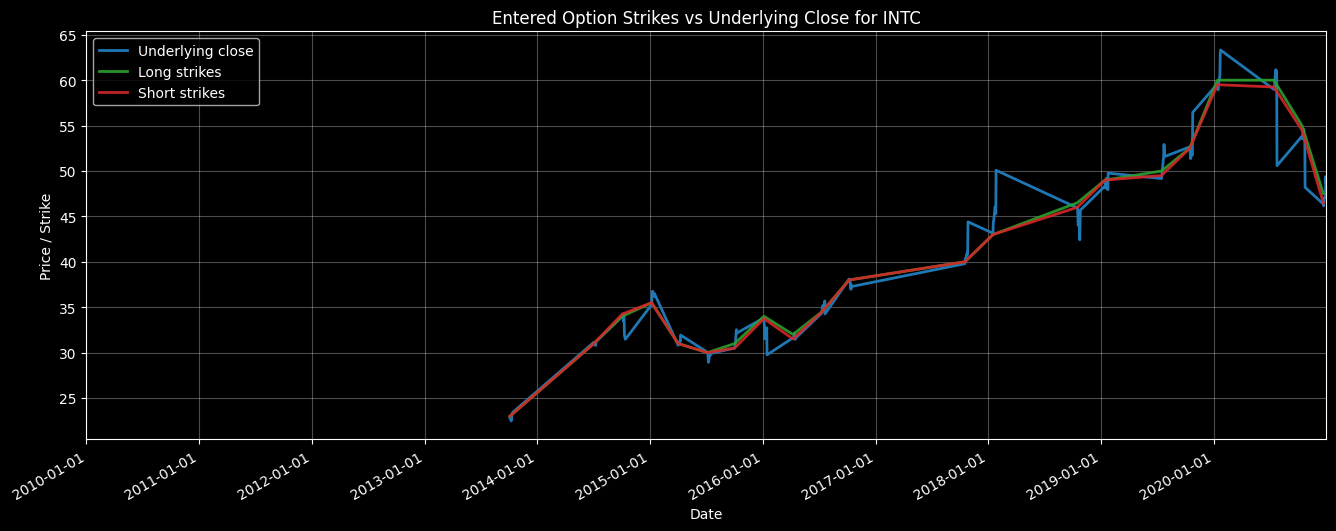

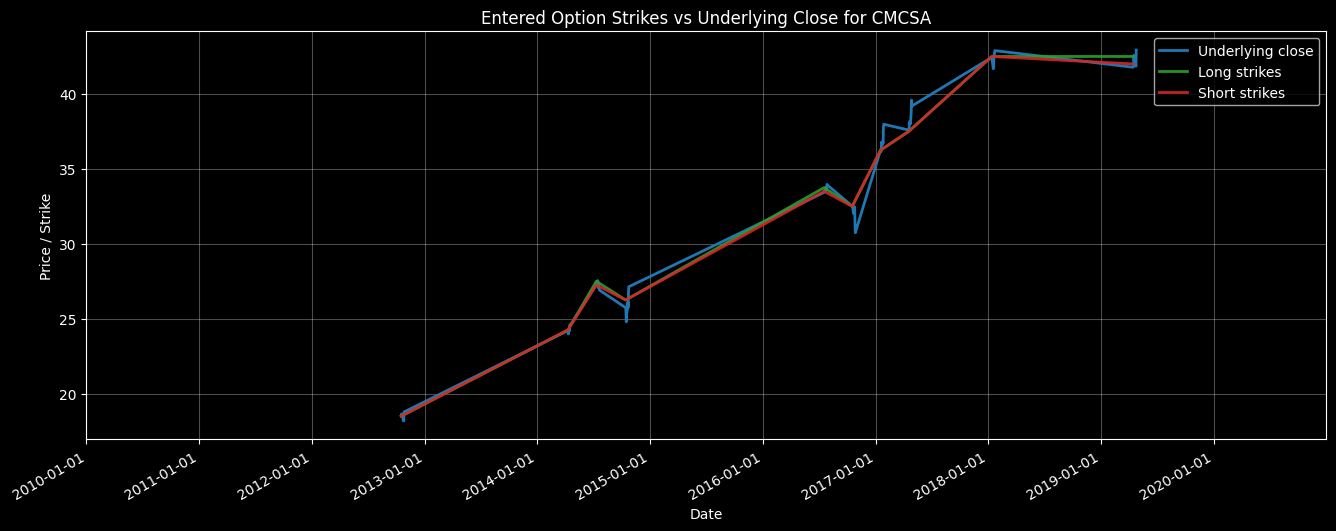

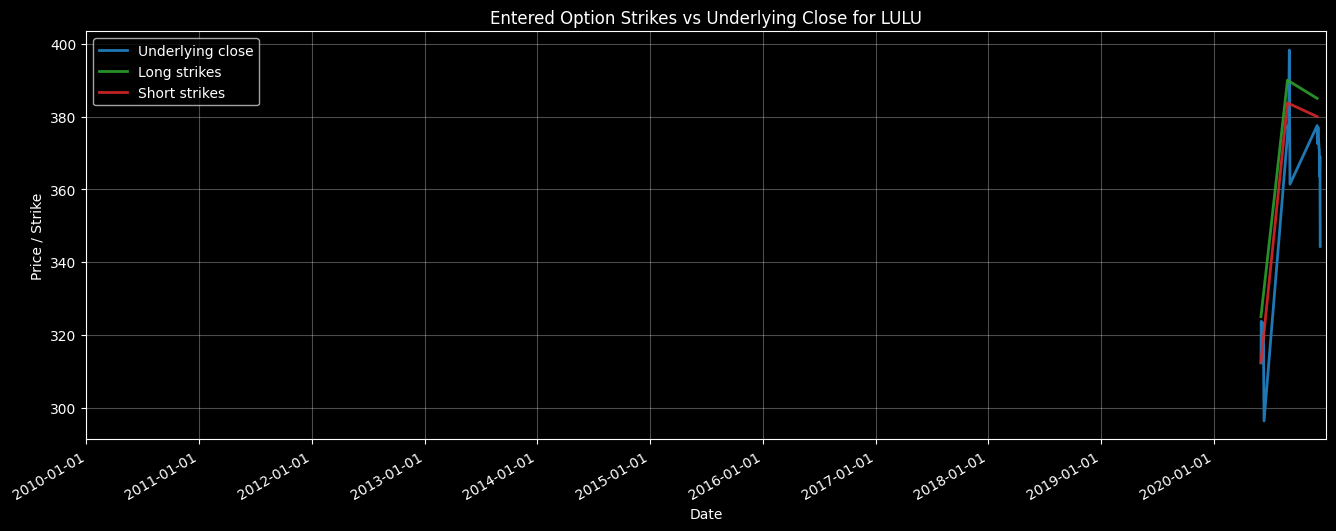

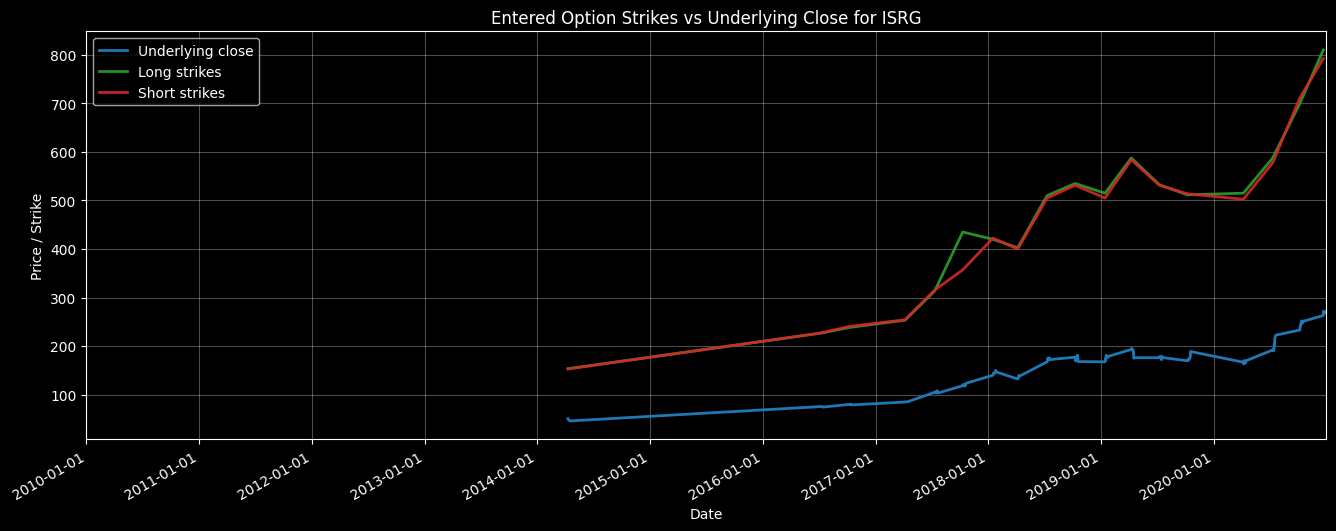

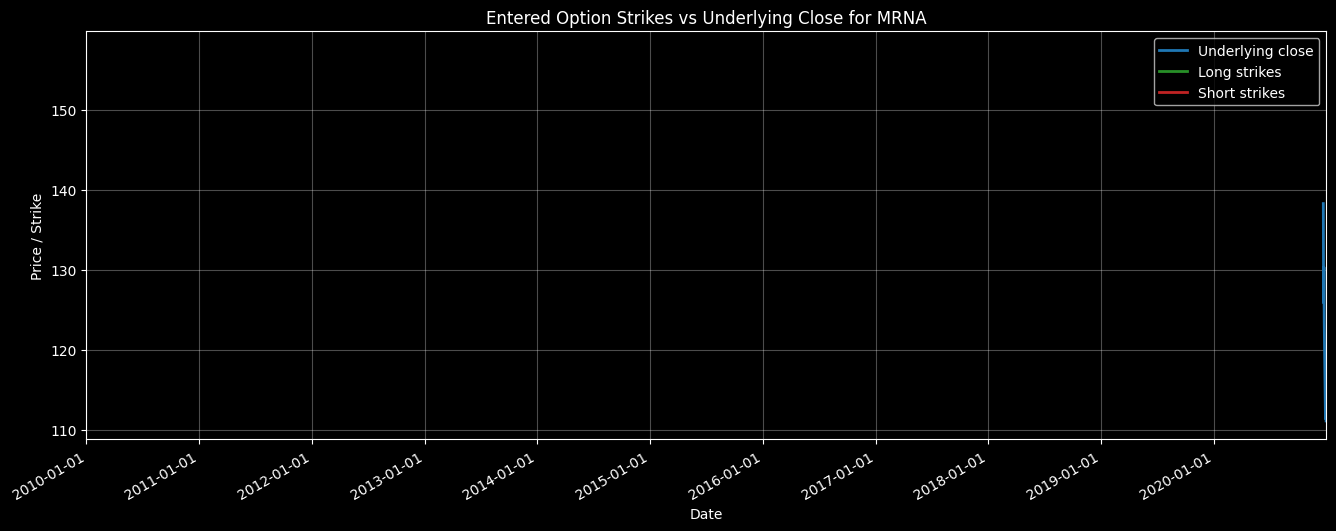

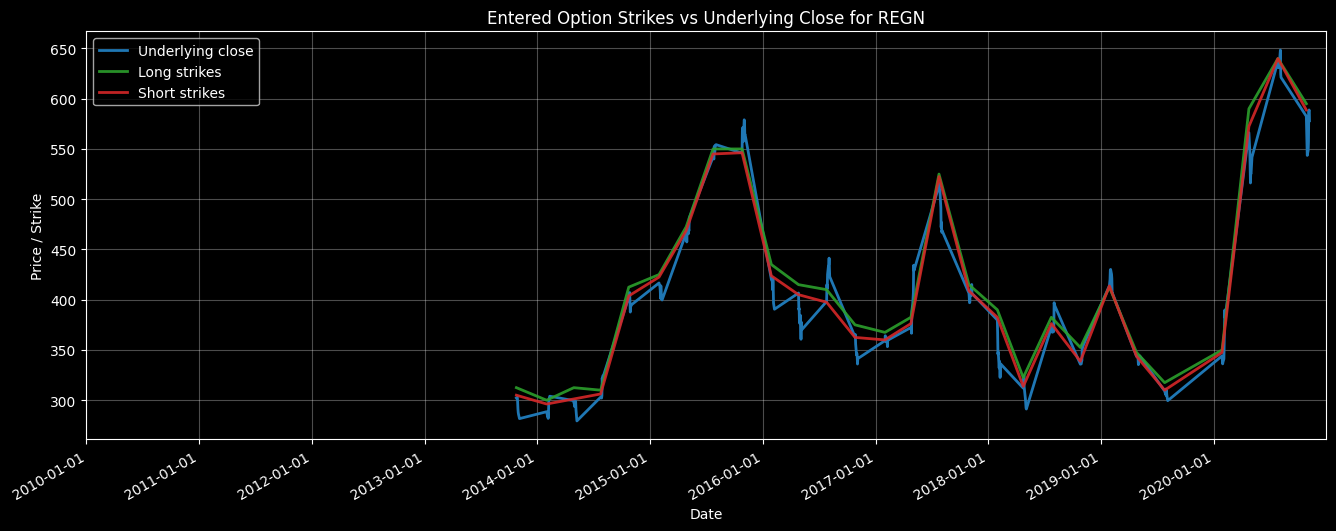

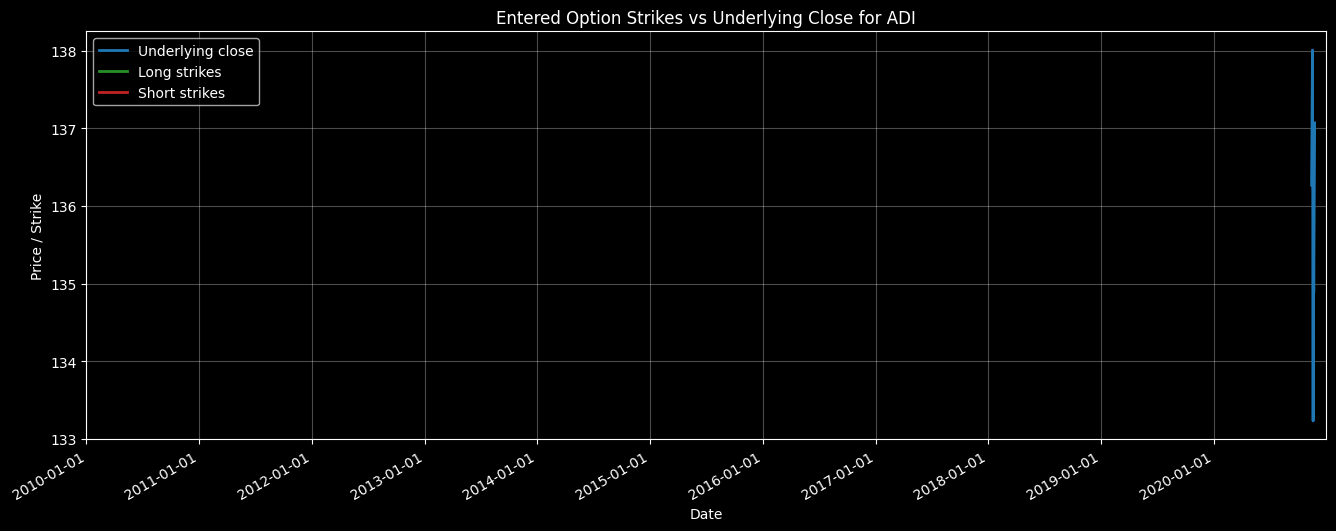

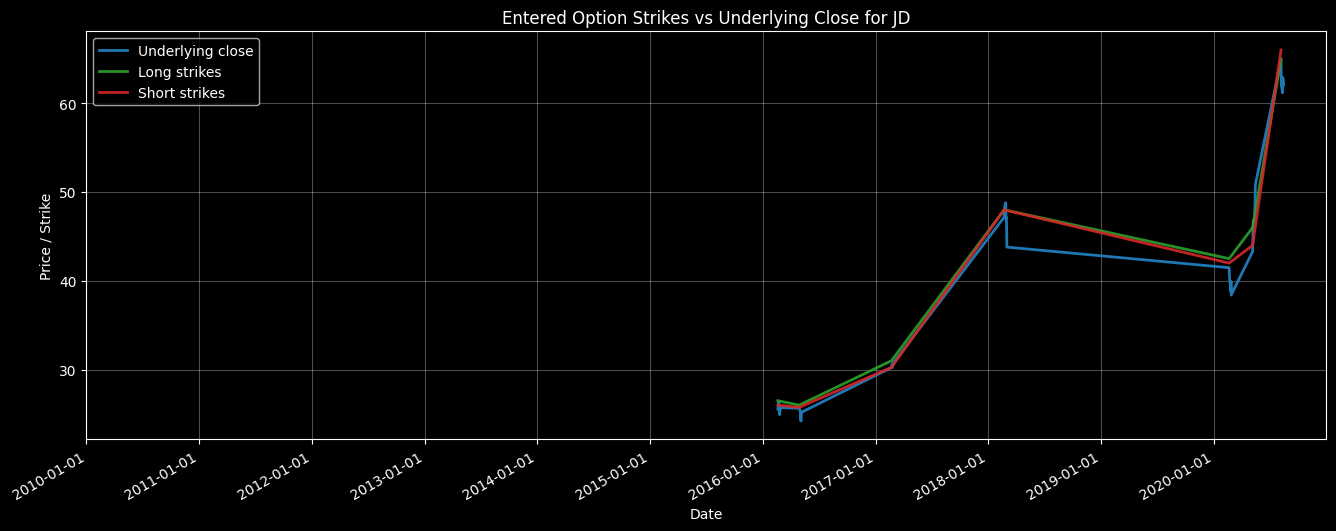

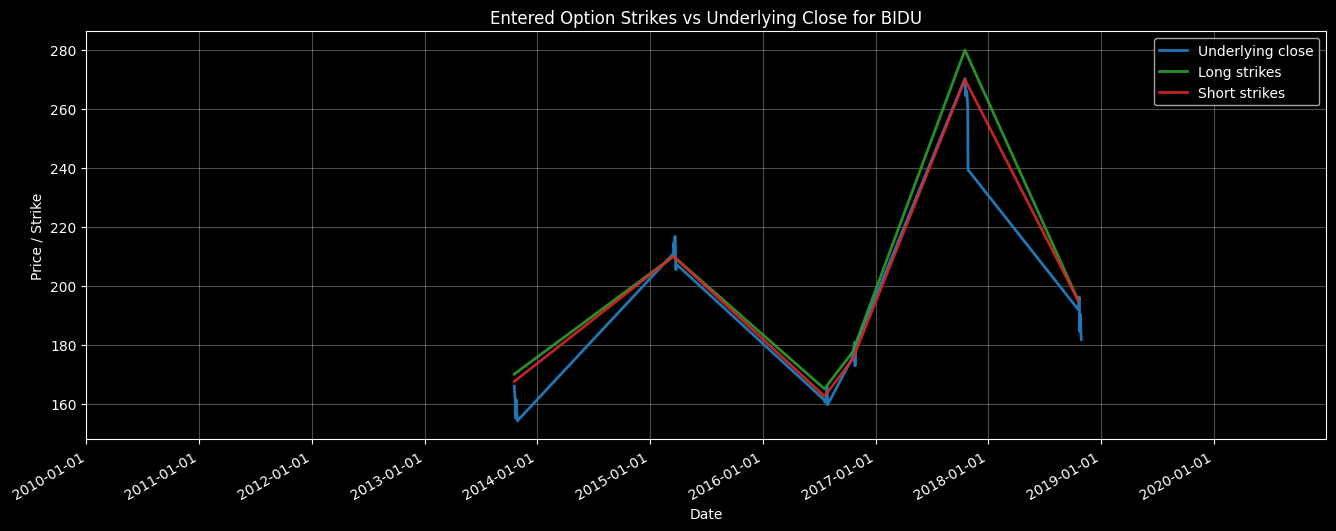

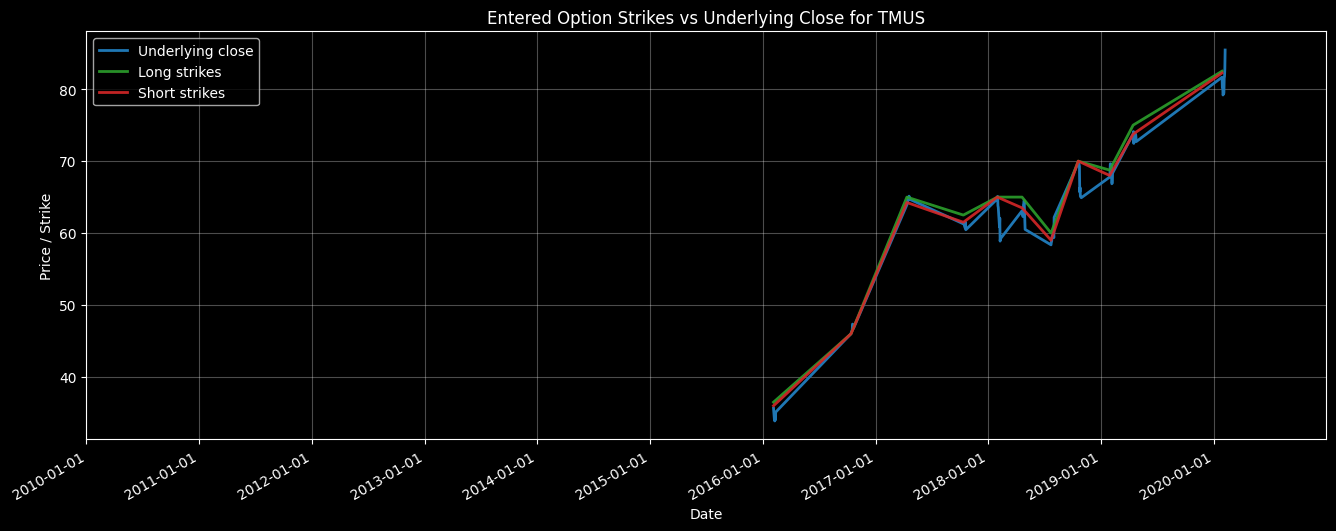

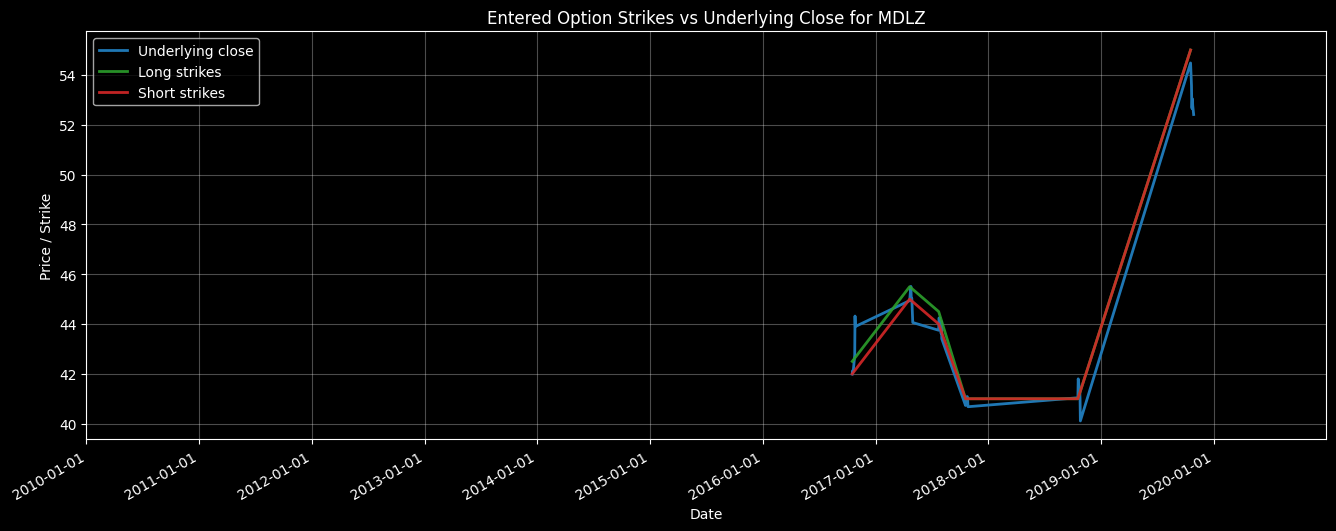

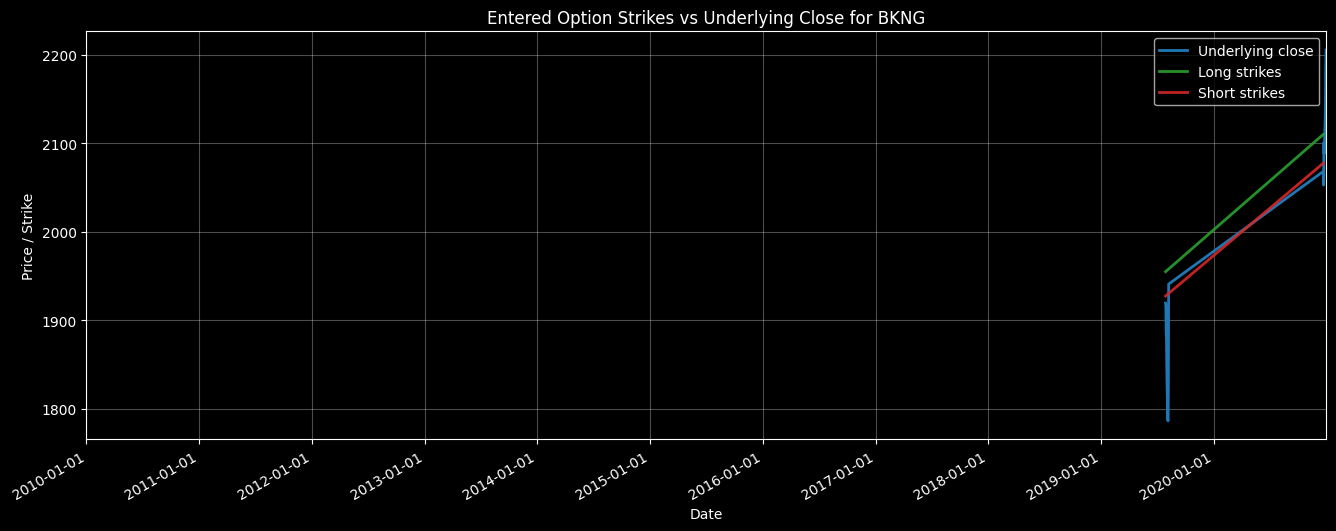

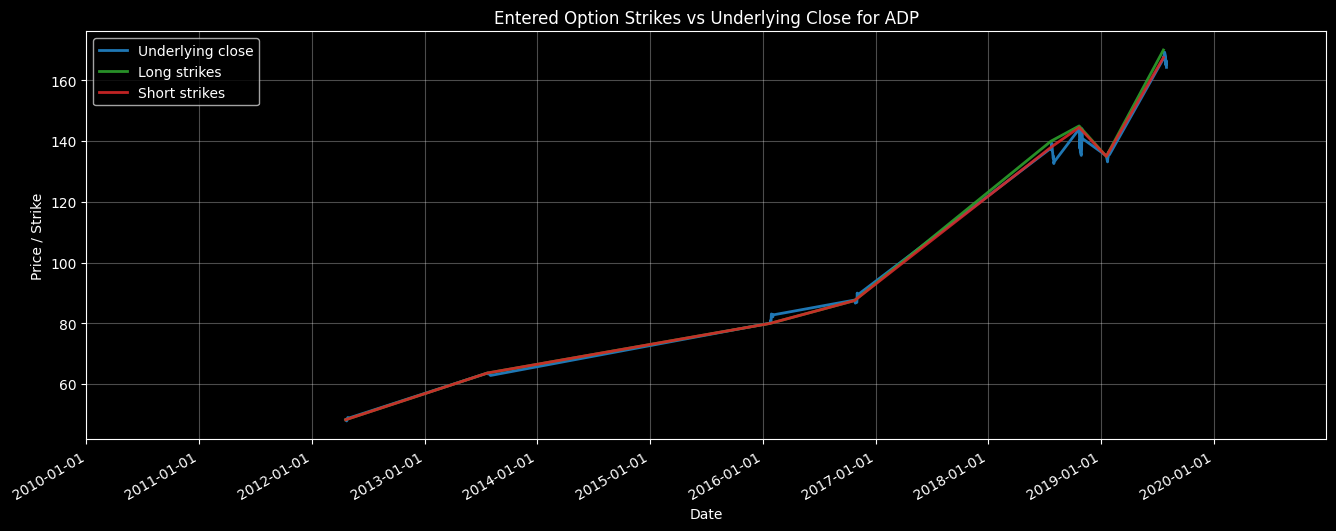

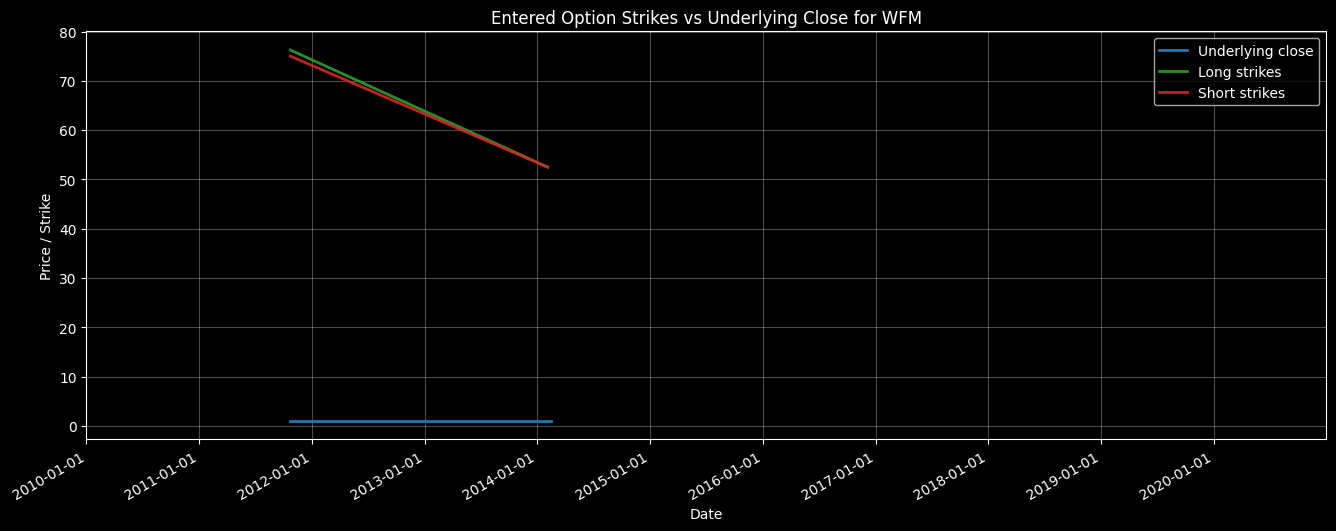

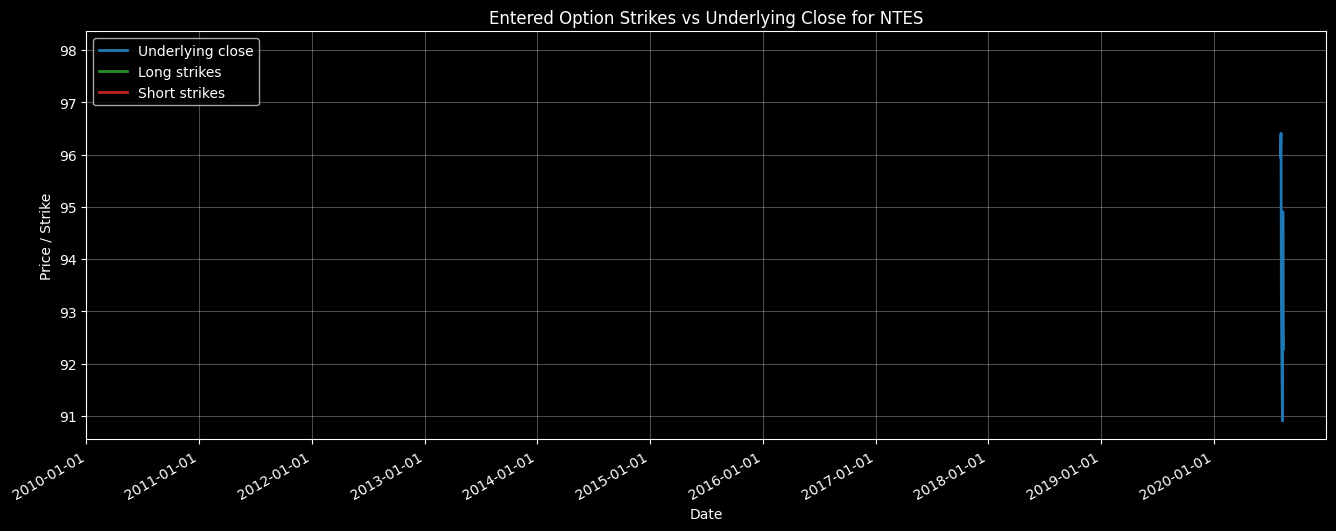

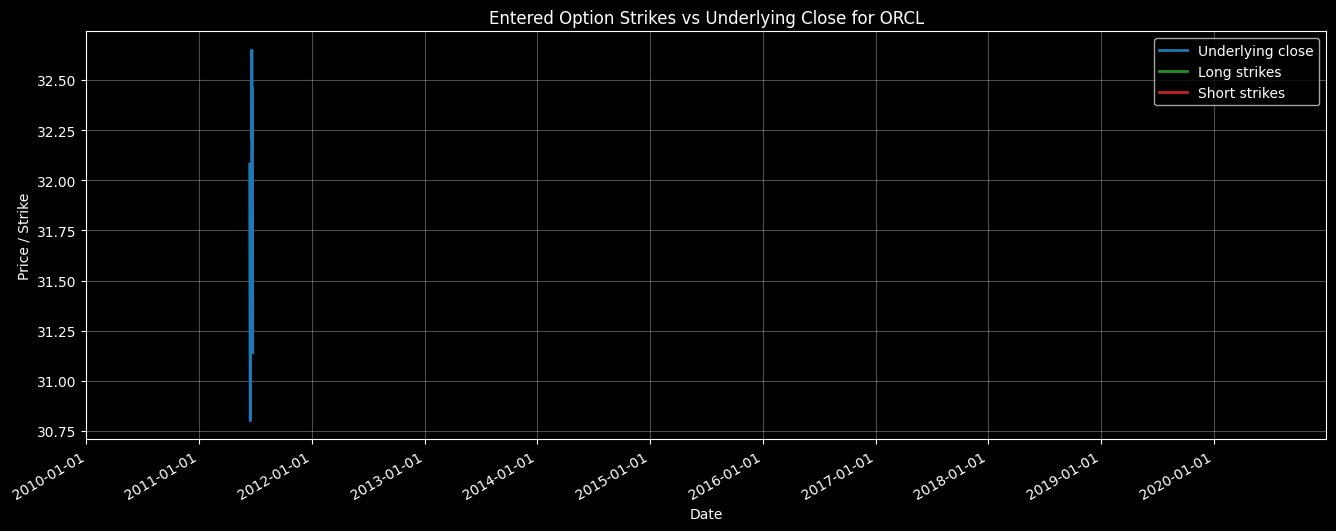

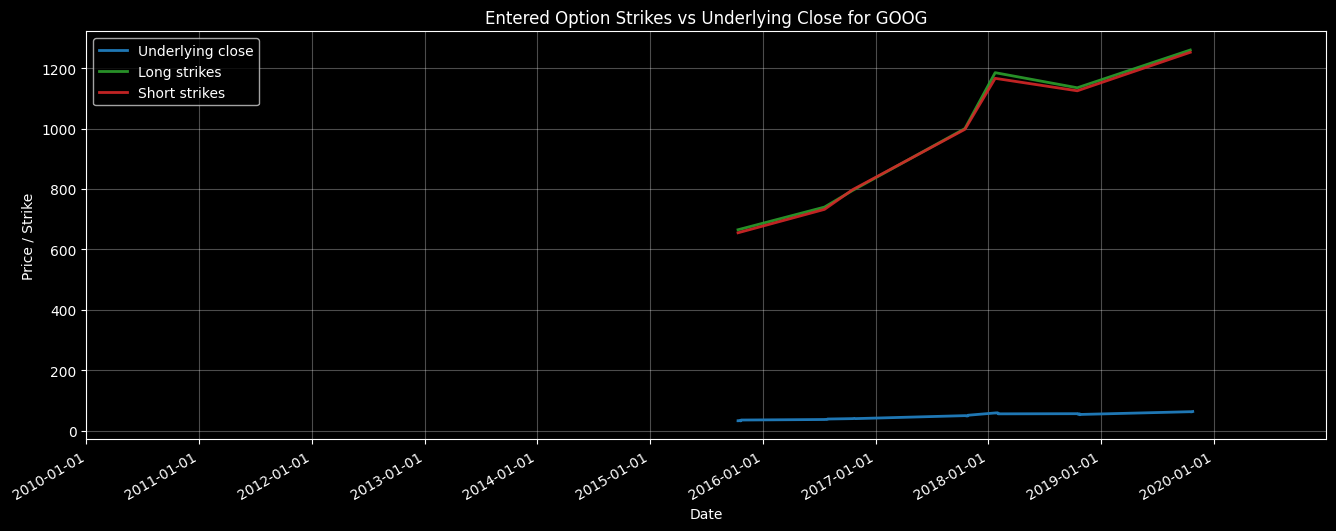

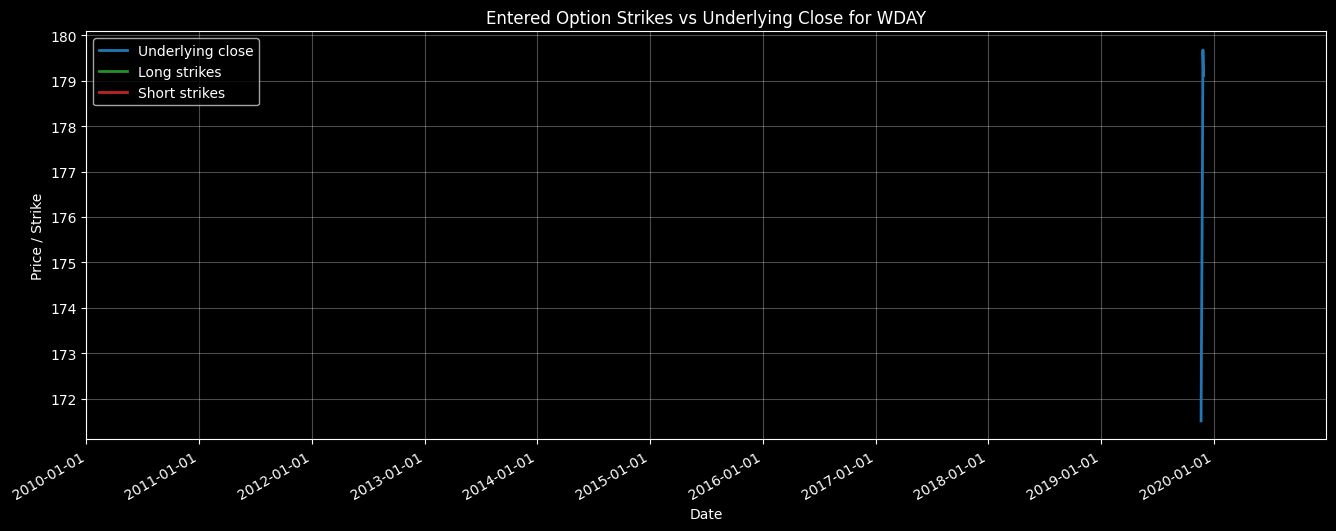

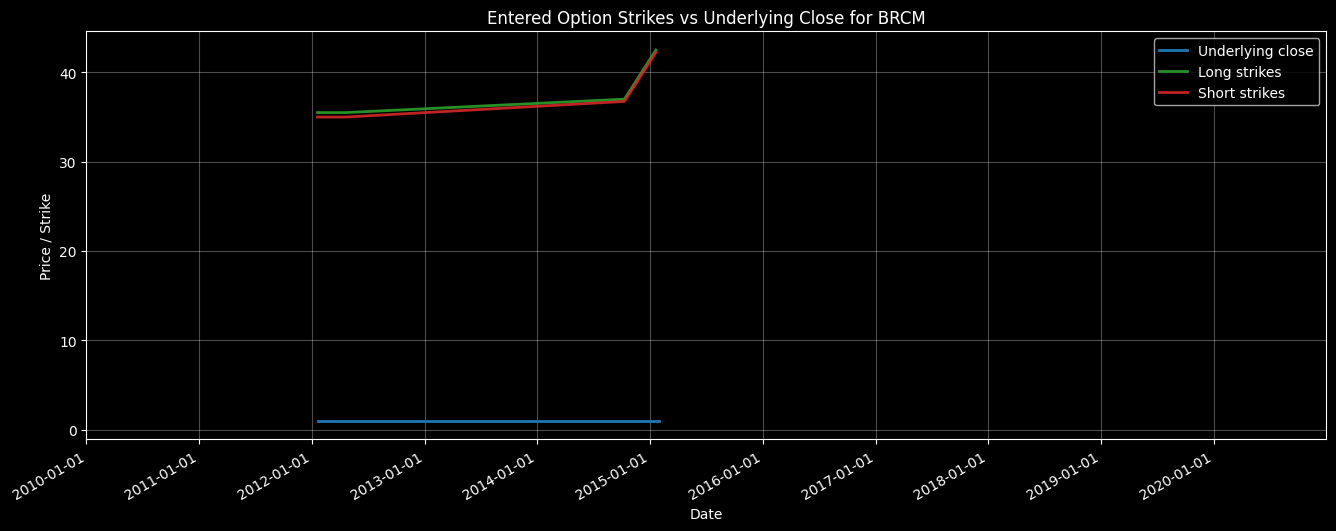

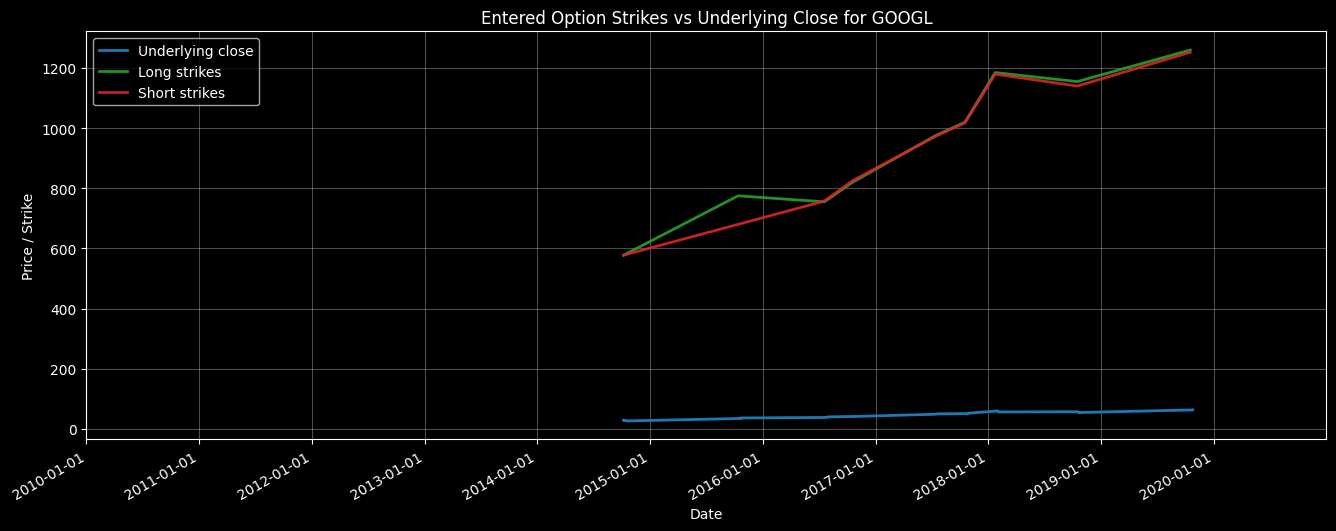

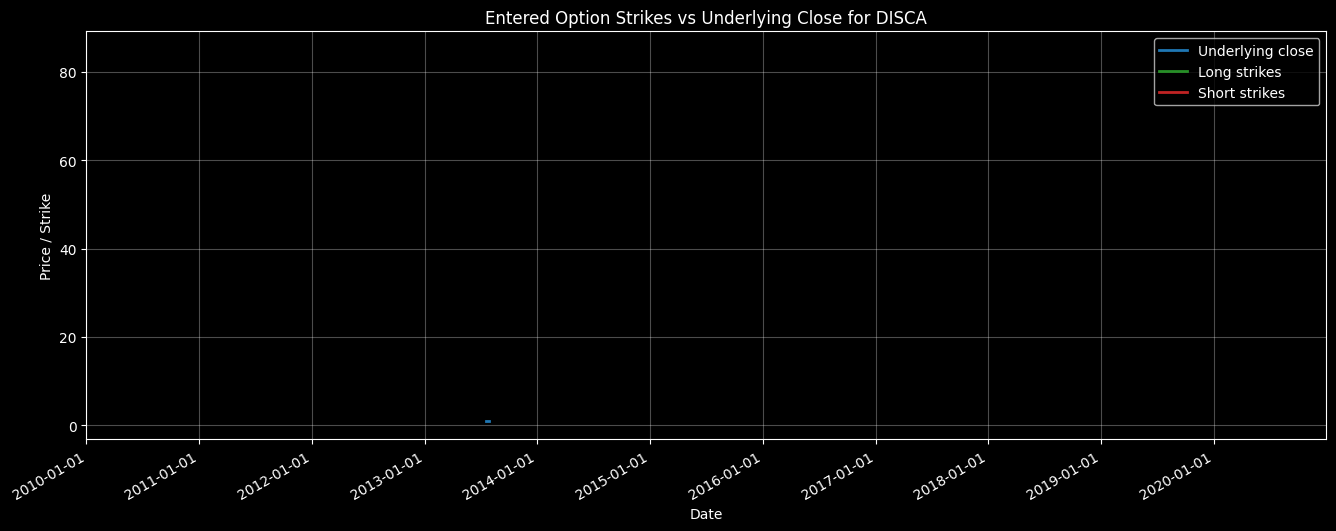

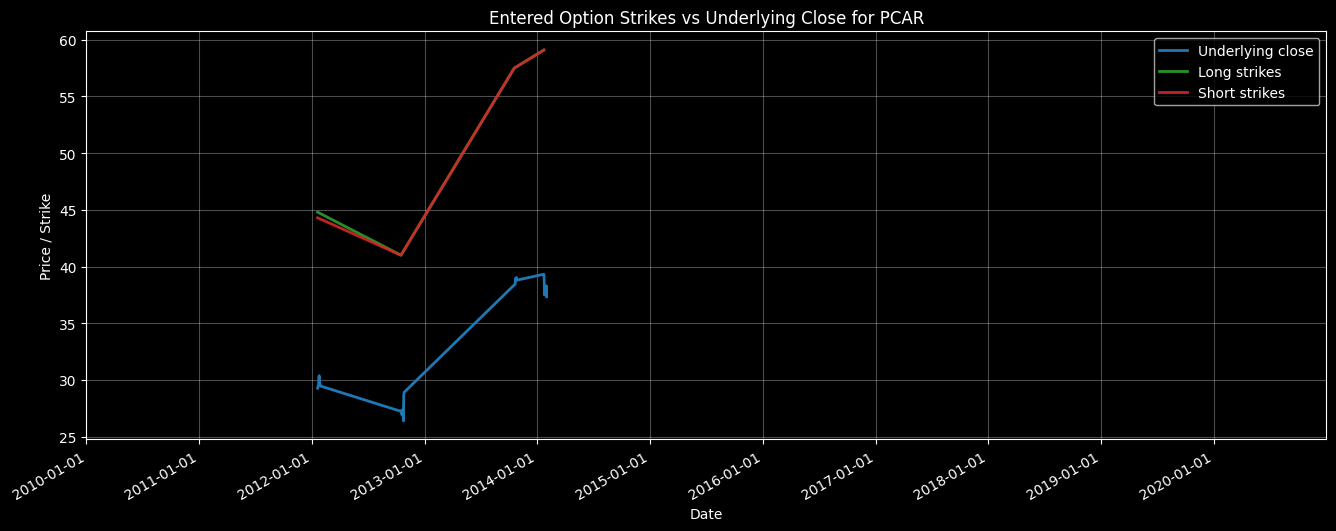

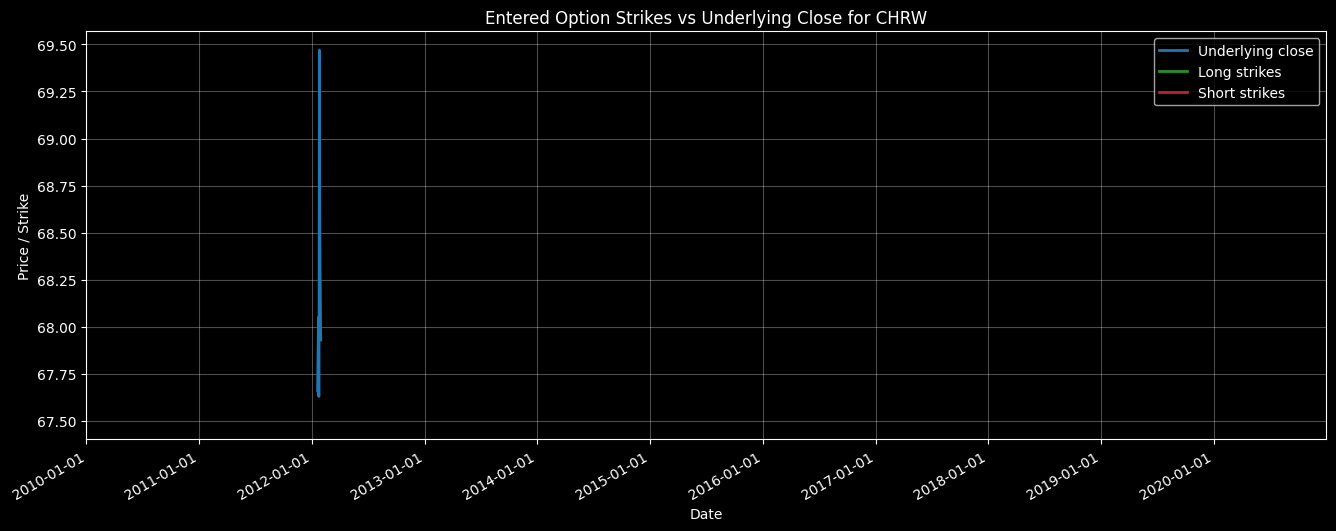

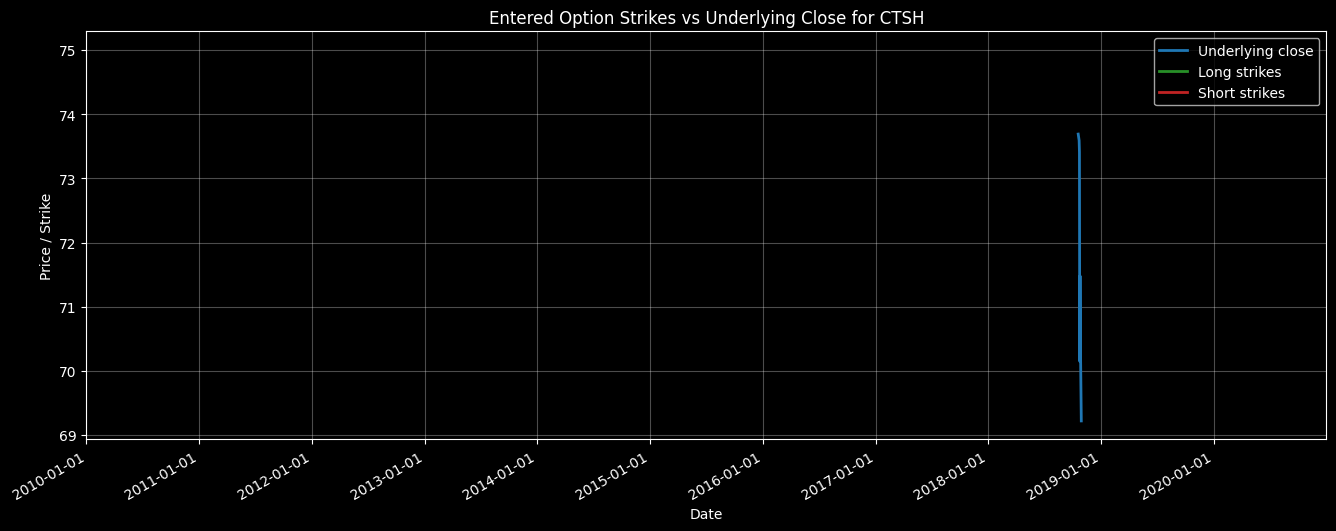

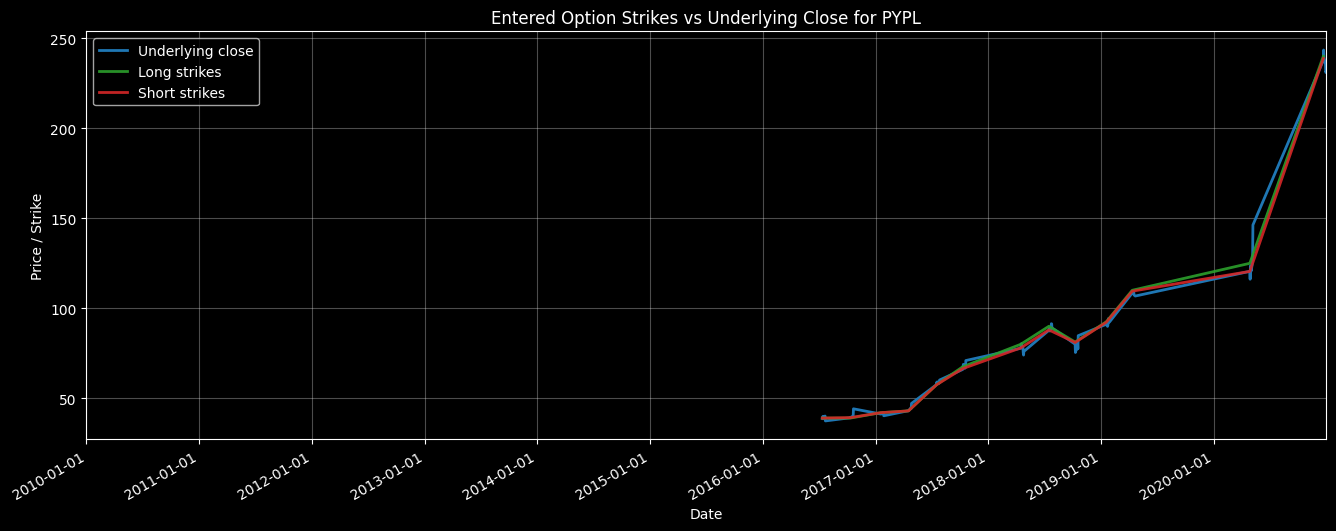

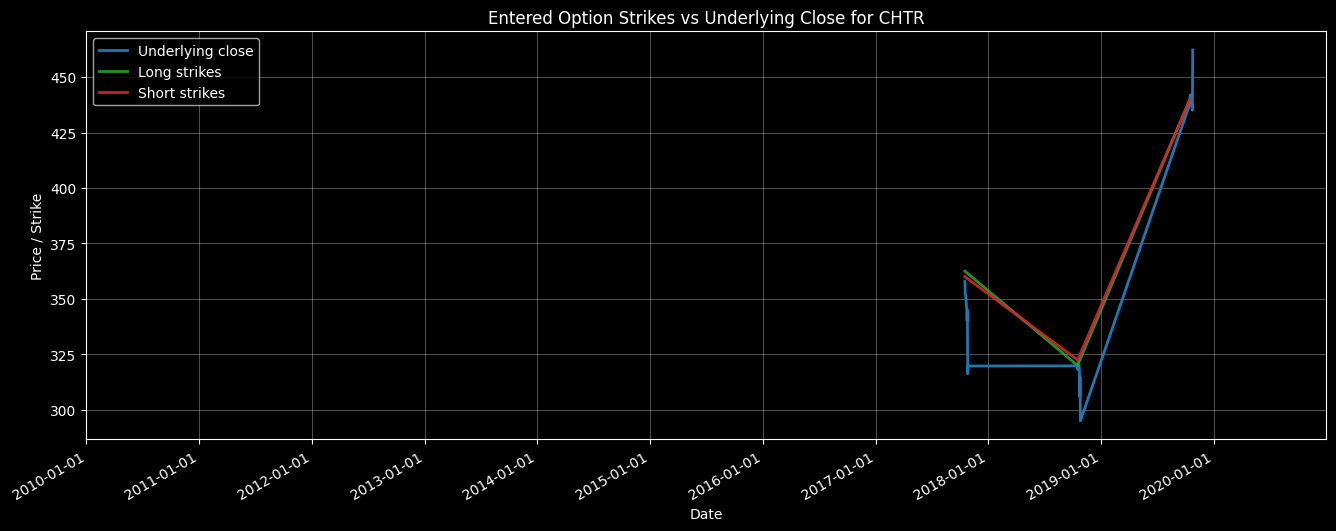

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx 
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

def plot_entry_strikes_lines(backtest_result, tick):
    """
    Plot entered option strikes over time as separate long/short lines,
    alongside the underlying close series. Returns (fig, ax).
    """
    trades = set()
    for snap in backtest_result.snapshots:
        trades.update(snap.trade_equities.keys())

    def norm_side(pos):
        if pos is None:
            return "unknown"
        if hasattr(pos, "value"):
            return str(pos.value).lower()
        s = str(pos).lower()
        if "long" in s:
            return "long"
        if "short" in s:
            return "short"
        return s

    long_strikes, short_strikes, underlying_series = {}, {}, {}

    for trade in trades:
        if trade._tick != tick:
            continue
        entry_date = trade.entry_data.entry_date
        px = trade.entry_data.price_series.get(entry_date)
        if px is None:
            continue

        side = norm_side(trade.entry_data.position_type)
        bucket = long_strikes if side == "long" else short_strikes
        bucket.setdefault(entry_date.to_datetime(), []).append(getattr(px, "strike", None))

        for _, contract_px in trade.entry_data.price_series.prices.items():
            u = getattr(contract_px, "underlying", None)
            if u is None or getattr(u, "date", None) is None:
                continue
            b, a = getattr(u, "bid", None), getattr(u, "ask", None)
            mid = (b + a) / 2 if b is not None and a is not None else b or a
            if mid is None:
                continue
            underlying_series[u.date.to_datetime()] = mid

    if not long_strikes and not short_strikes:
        return None, None
    
    def reduce_strikes(mapping):
        if not mapping:
            return [], []
        items = sorted(mapping.items(), key=lambda kv: kv[0])
        dates = [dt for dt, _ in items]
        strikes = [mean([s for s in vals if s is not None]) for _, vals in items]
        return dates, strikes

    long_dates, long_vals = reduce_strikes(long_strikes)
    short_dates, short_vals = reduce_strikes(short_strikes)

    fig, ax = plt.subplots(figsize=(16, 6))

    if underlying_series:
        u_dates, u_prices = zip(*sorted(underlying_series.items()))
        ax.plot(u_dates, u_prices, color="tab:blue", lw=2, label="Underlying close")

    if long_dates:
        ax.plot(long_dates, long_vals, color="tab:green", lw=2,
                label="Long strikes", alpha=0.9)
    if short_dates:
        ax.plot(short_dates, short_vals, color="tab:red", lw=2,
                label="Short strikes", alpha=0.9)

    ax.set_title(f"Entered Option Strikes vs Underlying Close for {tick}")
    ax.set_xlabel("Date")
    ax.set_xlim(start_date.to_datetime(), end_date.to_datetime())
    ax.set_ylabel("Price / Strike")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax

for tick in universe.ticks:
    fig, ax = plot_entry_strikes_lines(result, tick)

